In [142]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm
import json
import pandas as pd
from collections import defaultdict
import pandas as pd

# torch
import torch
import torch_geometric as pyg

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('style.mcstyle')
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# ili
import ili
from ili.dataloaders import NumpyLoader, StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PosteriorCoverage
from ili.utils import IndependentTruncatedNormal, Uniform, IndependentNormal

from tools.plot_tools import binned_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


In [143]:
mdir = './saved_models'

def r2logm(r):
    # see preprocessing.ipynb for this measurement
    coef = 0.36752
    intercept = -5.30640
    return (np.log10(r)-intercept)/coef

In [144]:
datanames = ['wC50', 'wC100', 'dC50', 'dC100']
runnames = ['base', 'gals_nle', 'summ_nle', 'gnn_npe']
modelnames = ['msig', 'pamico', 'mamp', 'gals_nle', 'summ_nle', 'gnn_npe']
Nfolds=10
folds = np.arange(Nfolds)

datatitles = dict(
    wC50='Wide $50\%$',
    wC100='Wide $100\%$',
    dC50='Deep $50\%$',
    dC100='Deep $100\%$'
)
modeltitles = dict(
    msig='$M-\sigma$',
    pamico='$M-\lambda$',
    mamp='MAMPOSSt',
    gals_nle='Galaxy-Net',
    summ_nle='Summary-Net',
    gnn_npe='Graph-Net'
)

## Check suite

In [145]:
to_count = ['posterior.pkl', 'msig.npz', 'posterior_samples.npy']

saved_models = os.listdir(mdir)
for d in datanames:
    for m in runnames:
        counter = defaultdict(int)
        for f in folds:
            dirname = f'apr24_{m}_{d}_f{f}'
            filelist = os.listdir(join(mdir, dirname))
            for fn in filelist:
                if fn in to_count:
                    counter[fn] += 1
        print(f'{d} {m}:')
        for fn, c in counter.items():
            print(f'\t{fn}: {c}')
    print()

wC50 base:
	msig.npz: 10
wC50 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC50 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC50 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 9

wC100 base:
	msig.npz: 10
wC100 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC100 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC100 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10

dC50 base:
	msig.npz: 10
dC50 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC50 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC50 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10

dC100 base:
	msig.npz: 10
dC100 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC100 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC100 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10



## Load Everything

In [146]:
# load train/test
header = 'APR24'
datadir = './data/processed'

theta, fold, ids, richs, zclus = {}, {}, {}, {}, {}
for d in datanames:
    dirpath = join(datadir, f'{header}{d}')
    print('Loading:', dirpath)
    theta[d] = np.load(join(dirpath, 'theta_batch.npy'))
    fold[d] = np.load(join(dirpath, 'folds_batch.npy'))
    ids[d] = np.load(join(dirpath, 'ids_batch.npy'))
    _s = np.load(join(dirpath, 'x_sum.npy'))
    richs[d] = _s[:,3]
    zclus[d] = np.load(join(dirpath, 'metas_batch.npy'))

Ndata = {d: len(theta[d]) for d in datanames}
print(Ndata)

Loading: ./data/processed/APR24wC50
Loading: ./data/processed/APR24wC100
Loading: ./data/processed/APR24dC50
Loading: ./data/processed/APR24dC100
{'wC50': 840, 'wC100': 907, 'dC50': 1998, 'dC100': 2014}


In [147]:
Nsamp = 100
preds = defaultdict(dict)
for d in datanames:
    for r in runnames:
        # setup
        if r == 'base':
            preds[d]['msig'] = np.ones((Ndata[d], 2))*np.nan
            preds[d]['pamico'] = np.ones((Ndata[d], 2))*np.nan
        else:
            preds[d][r] = np.empty((Ndata[d], Nsamp, 1))

        # load
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            if r == 'base':
                # Msig
                samplefile = join(mdir, dirname, 'msig.npz')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                place_ids = np.searchsorted(ids[d], s['ids'])
                np.put(preds[d]['msig'][:,0], place_ids, s['pred'])
                np.put(preds[d]['msig'][:,1], place_ids, s['std'])


                # Pamico
                samplefile = join(mdir, dirname, 'Pamico.npz')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                place_ids = np.searchsorted(ids[d], s['ids'])
                np.put(preds[d]['pamico'][:,0], place_ids, s['pred'])
                np.put(preds[d]['pamico'][:,1], place_ids, s['std'])


            else:
                # ML models
                samplefile = join(mdir, dirname, 'posterior_samples.npy')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                s = np.swapaxes(s, 0, 1)
                s = s[:, :Nsamp]  # subsample if necessary
                preds[d][r][fold[d] == f] = s

Skipping apr24_gnn_npe_wC50_f6


In [148]:
# load mamposst

mamnames = {
    'wC50': 'wide50', 'wC100': 'wide100', 'dC50': 'deep50', 'dC100': 'deep100'    
}
modeldir = './saved_models/mamposst/'

for k, v in mamnames.items():
    isamp = pd.read_csv(join(modeldir, f'result_MockFS_NewAMICO_{v}CUT.dat'), 
                        delimiter=' ', skipinitialspace=True)
    isamp['id'] = isamp['#ClusterID'].astype(int)
    isamp
    # convert r200 to logm
    for c in isamp.columns:
        if 'r200' not in c:
            continue
        isamp['logm'+c[4:]] = r2logm(isamp[c])

    # put in preds
    preds[k]['mamp'] = np.ones((Ndata[k], 5))*np.nan
    place_ids = np.searchsorted(ids[k], isamp['id'].values)
    _s = isamp[['logmlow(68)', 'logmup(68)', 'logmlow(95)', 'logmup(95)', 'logmMAM']].values
    preds[k]['mamp'][place_ids] = _s

In [149]:
# calculate percentiles from predictions
q = 100*np.array([0.16, 0.84, 0.5, 0.025, 0.975])
percs = defaultdict(dict)
for d in datanames:
    for m in modelnames:
        if m == 'msig' or m == 'pamico':
            t_ = preds[d][m]
            percs[d][m] = np.stack(
                [t_[:,0]-t_[:,1], t_[:,0]+t_[:,1], t_[:,0], t_[:,0]-2*t_[:,1], t_[:,0]+2*t_[:,1]], 
                axis=1).T
        elif m == 'mamp':
            if m not in preds[d]:
                continue
            t_ = preds[d][m]
            percs[d][m] = np.stack(
                [t_[:,0], t_[:,1], t_[:,4], t_[:,2], t_[:,3]],
                axis=1).T
        else:
            t_ = preds[d][m]
            percs[d][m] = np.percentile(t_, q, axis=1)[...,0]
# percs is of shape (5, Ndata)
# dim 0 is of order [16, 84, 50, 2.5, 97.5]

`preds` is organized by the following...

for base models:
`preds[dataname][modelname] = (Ntest, 2)` (mean, std)

for neural models:
`preds[dataname][modelname] = (Ntest, Nsamp, 1)`

## Check loss

In [212]:
def plot_loss(loss, ax, errs=[0.6, 1], color=None, **kwargs):
    # prepare losses
    L = max([len(x) for x in loss])
    lossnan = np.ones((len(loss), L))*np.nan
    for i, l in enumerate(loss):
        lossnan[i, :len(l)] = l
    
    q = []
    for e in errs:
        q += [0.5-e/2, 0.5+e/2]
    q += [0.5]
    q = np.array(q)*100
    
    x_ = range(L)
    percs = np.nanpercentile(lossnan, q=q, axis=0)
    for i in range(len(errs)):
        ax.fill_between(x_, percs[2*i], percs[2*i+1], alpha=0.2, color=color)
    ax.plot(x_, percs[-1], color=color, **kwargs)

wC50
wC100
dC50
dC100


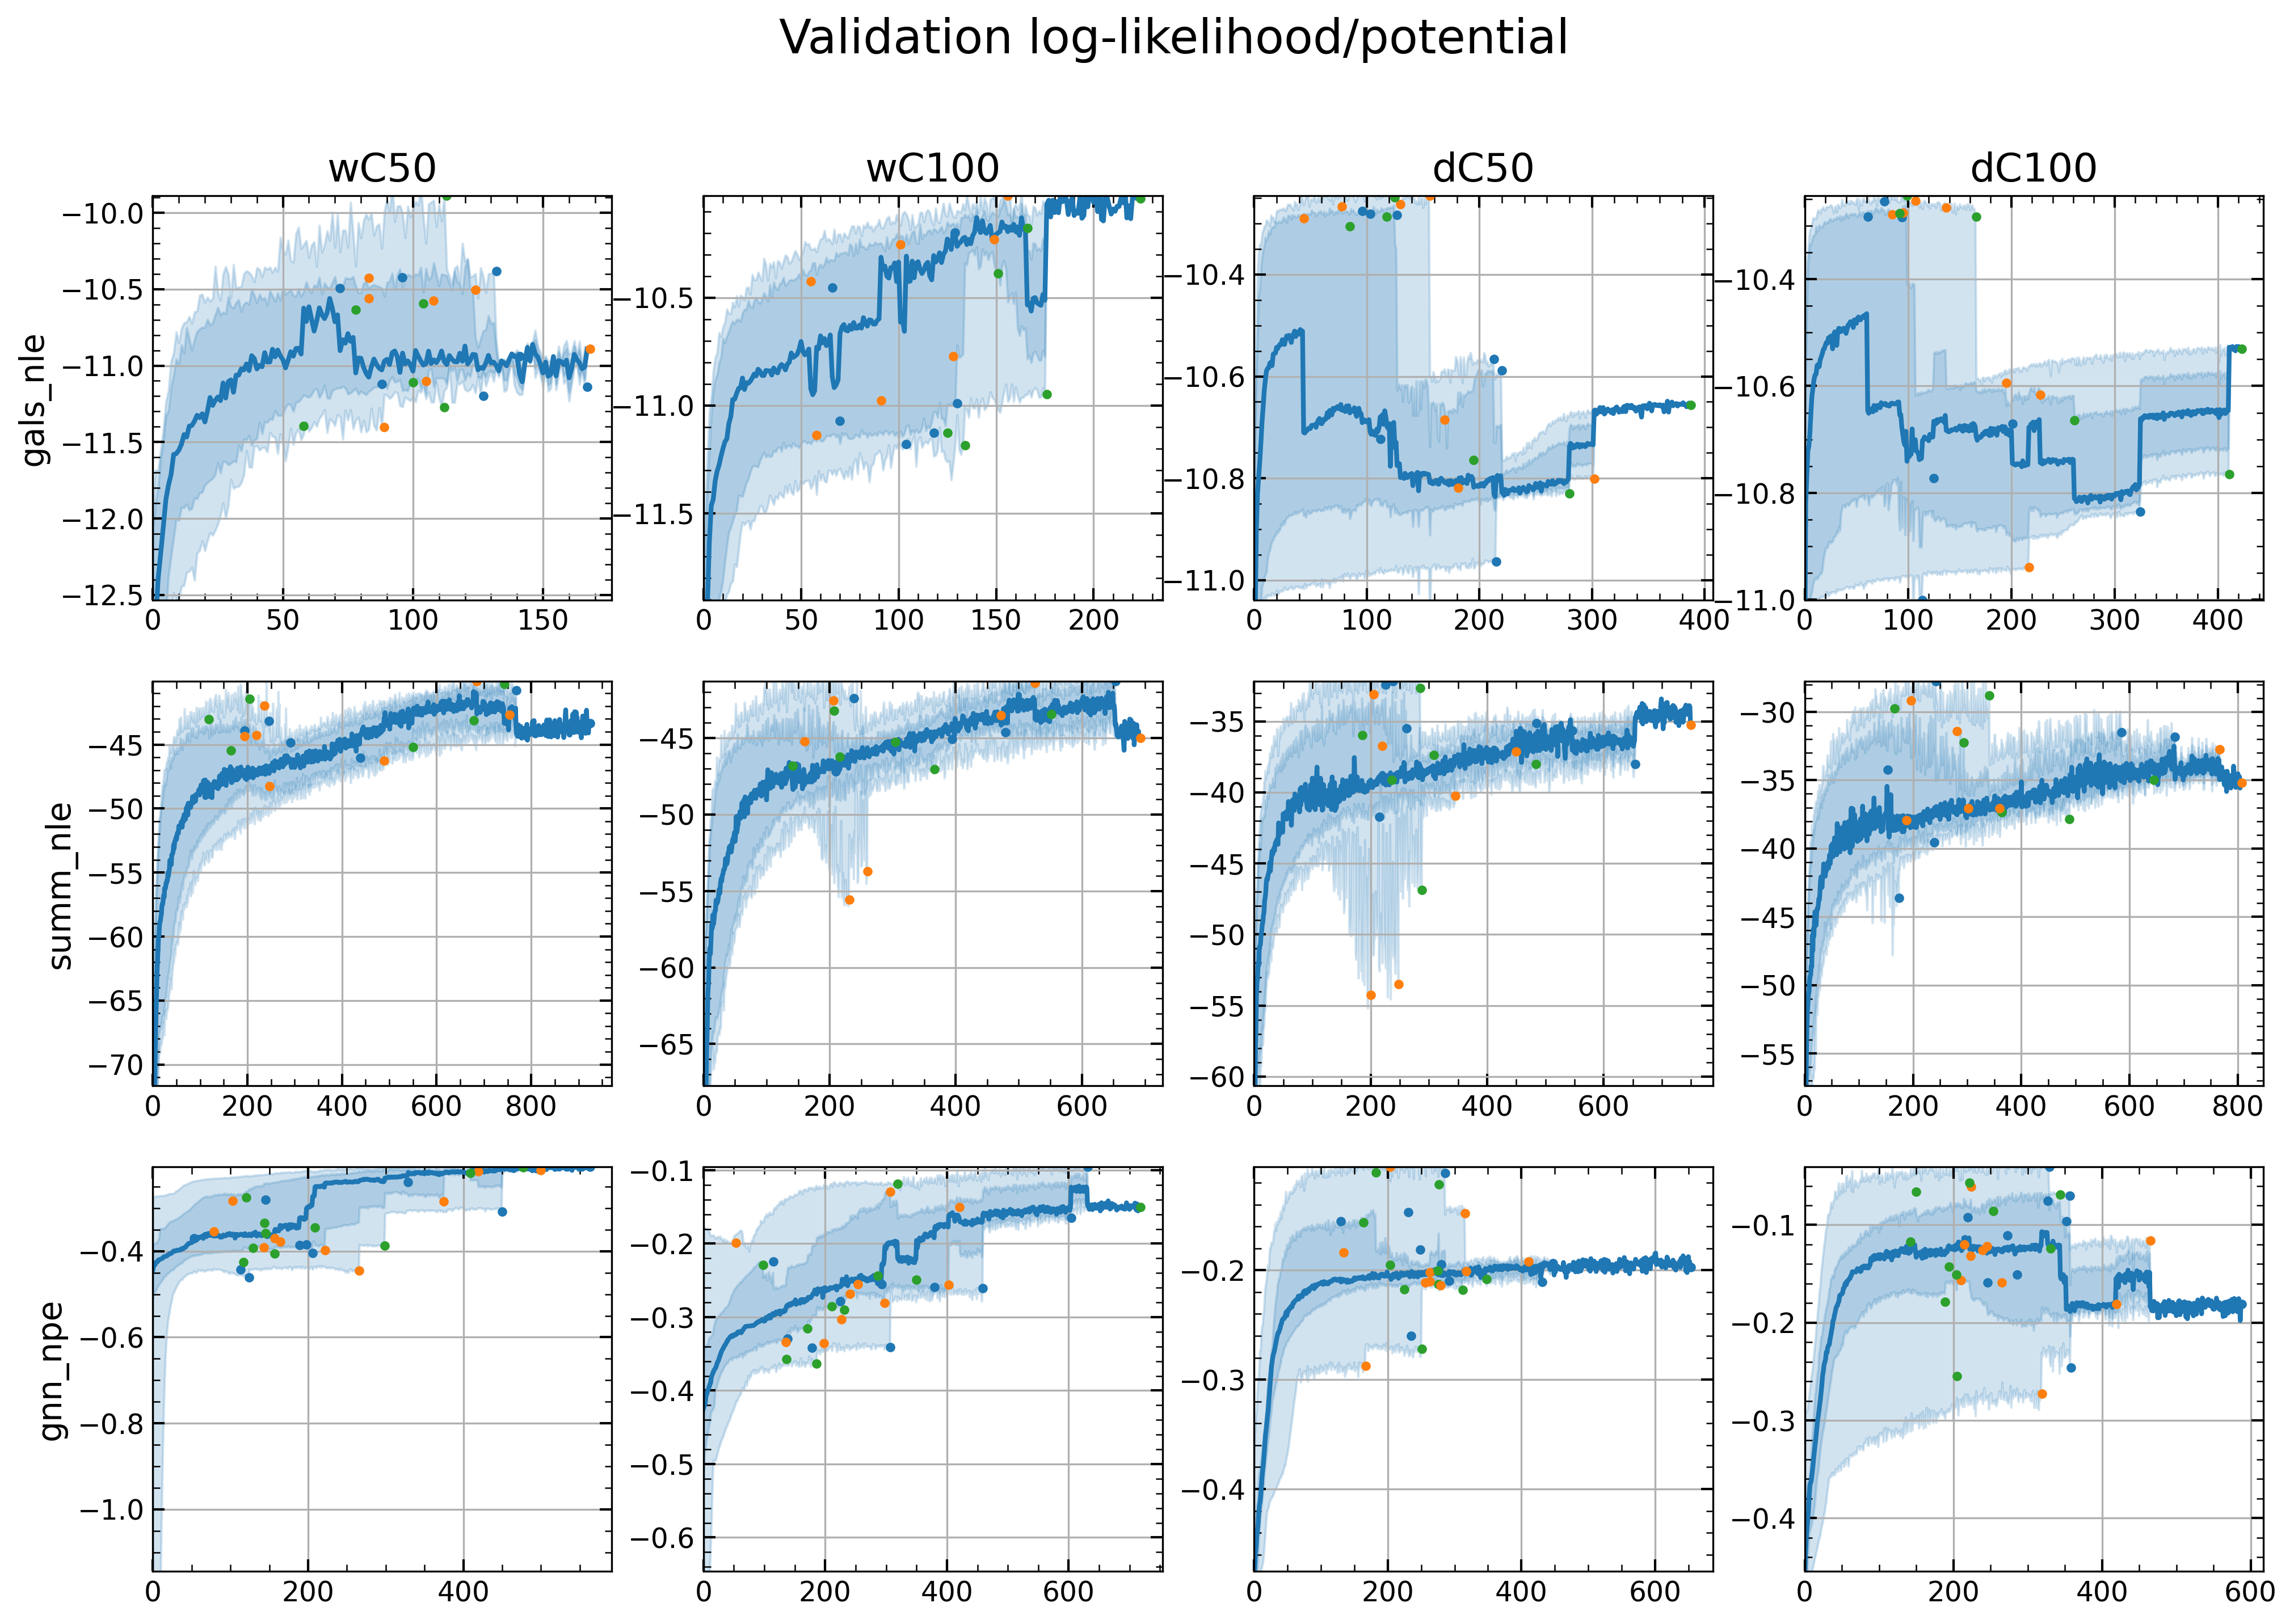

In [213]:
W, H = len(datanames), len(runnames)-1
fig, axs = plt.subplots(H, W, figsize=(W*4, H*3.5), sharex=False, sharey=False)
for i, d in enumerate(datanames):
    print(d)
    for j, r in enumerate(runnames[1:]):
        # load summaries
        summs = []
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            fn = join(mdir, dirname, 'summary.json')
            if not os.path.exists(fn):
                continue
            with open(fn, 'r') as f:
                summs.append(json.load(f))
        
        # append losses
        loss, valloss = [], []
        for s in summs:
            for m in s:
                loss.append(m['training_log_probs'])
                valloss.append(m['validation_log_probs'])

        
        ax = axs[j, i]
        # ax.semilogx()
        plot_loss(valloss, ax, color='C0', label='Training')
        for k, l in enumerate(valloss):
            ax.plot(len(l), l[-1], '.', color=f'C{k%3}')
        ymin = np.min([x[10] for x in valloss])
        ymax = np.max([x[-1] for x in valloss])
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(0)

        if j == 0:
            ax.set_title(d)
        if j == W-1:
            ax.set_xlabel('Epoch')
        if i == 0:
            ax.set_ylabel(r)

fig.suptitle('Validation log-likelihood/potential', fontsize=20);

wC50
wC100
dC50
dC100


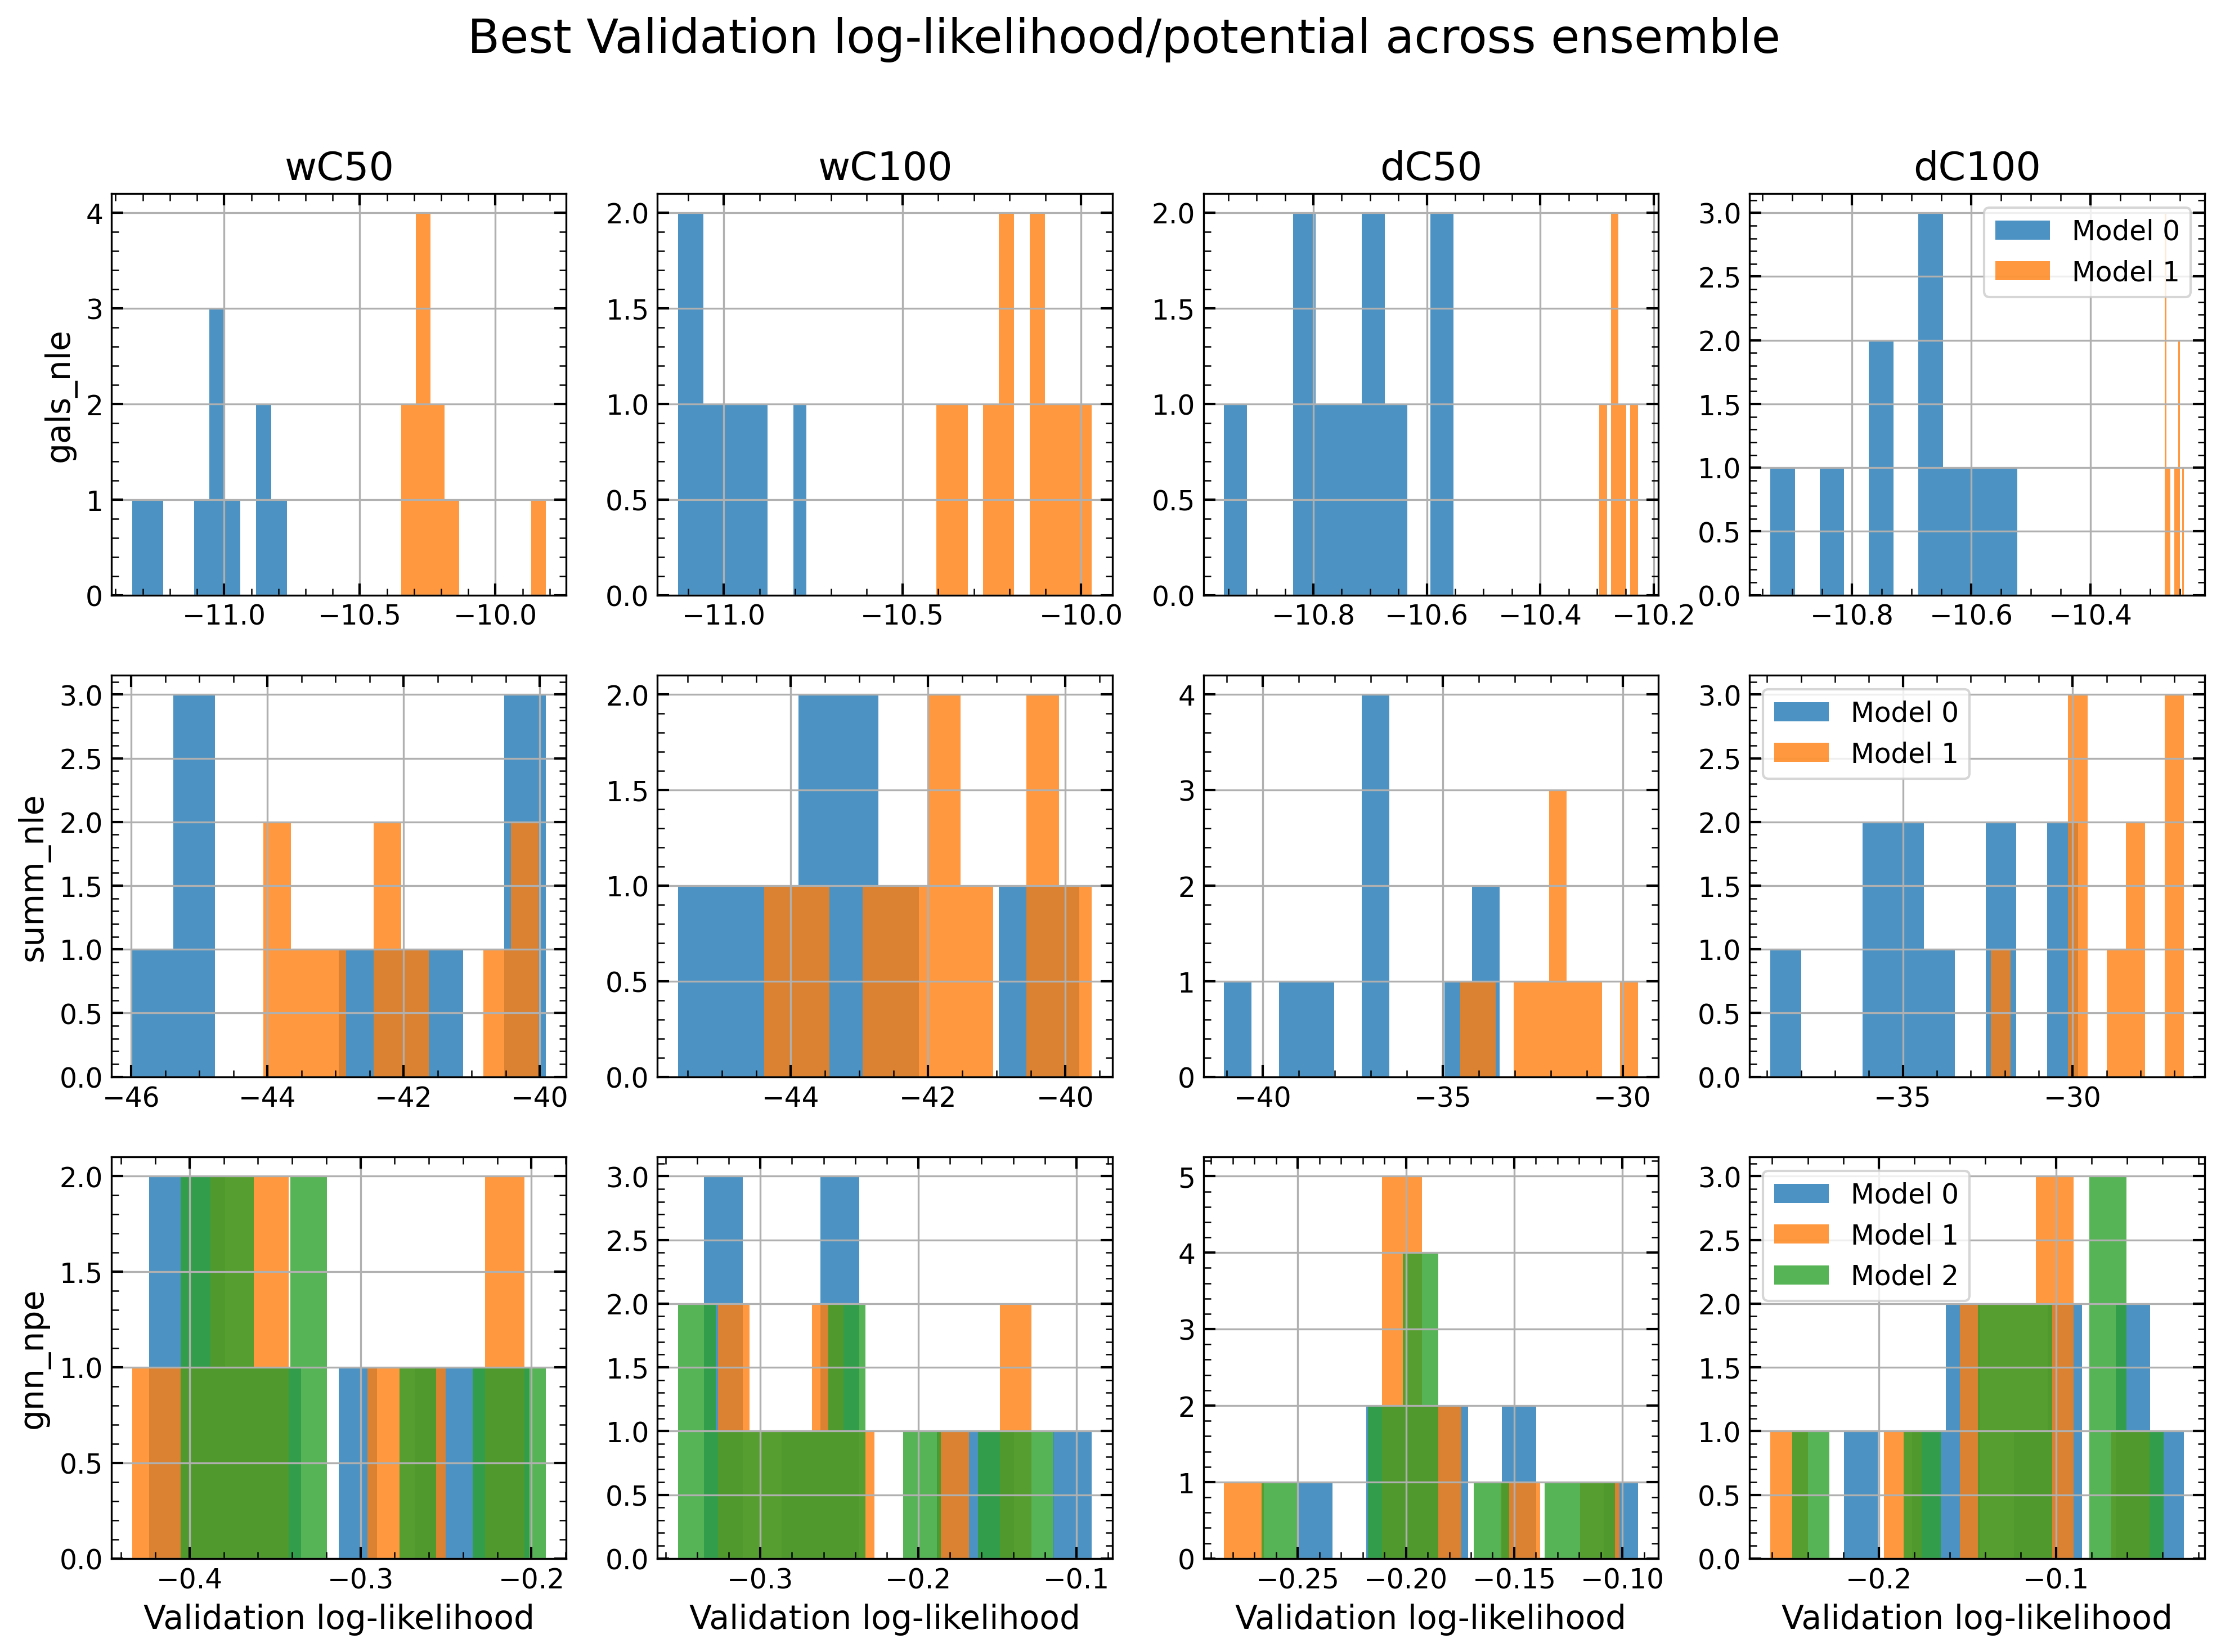

In [214]:
W, H = len(datanames), len(runnames)-1
fig, axs = plt.subplots(H, W, figsize=(W*4, H*3.5), sharex=False, sharey=False)
for i, d in enumerate(datanames):
    print(d)
    for j, r in enumerate(runnames[1:]):
        # load summaries
        summs = []
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            fn = join(mdir, dirname, 'summary.json')
            if not os.path.exists(fn):
                continue
            with open(fn, 'r') as f:
                summs.append(json.load(f))
        
        # append final
        valloss = []
        for s in summs:
            valloss.append([m['best_validation_log_prob'] for m in s])
        try:
            valloss = np.array(valloss)
        except ValueError:
            continue
        if len(valloss.shape)==3:
            valloss = valloss[...,1]
        valloss[~np.isfinite(valloss)] = -16

        
        ax = axs[j, i]
        # ax.semilogx()
        for k in range(valloss.shape[-1]):
            ax.hist(valloss[:,k], alpha=0.8, label=f'Model {k}')
        # ax.hist(valloss, label='r')
        # ymin = np.min([x[10] for x in valloss])
        # ymax = np.max([x[-1] for x in valloss])
        # ax.set_ylim(ymin, ymax)
        # ax.set_xlim(0)

        if j == 0:
            ax.set_title(d)
        if j == H-1:
            ax.set_xlabel('Validation log-likelihood')
        if i == 0:
            ax.set_ylabel(r)
        if i == W-1:
            ax.legend()

fig.suptitle('Best Validation log-likelihood/potential across ensemble', fontsize=20);

## Plot Examples

In [35]:
# Plot single cluster example
data = pd.read_csv(
    'data/raw/deep_all_03042024.dat', delimiter=' ', index_col=False,
    skipinitialspace=True)
data = pd.DataFrame(
    data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)
data = data.groupby('Cl_id')
idx = 227  # np.random.choice(list(data.groups.keys()))
clu = data.get_group(idx)

In [36]:
c = 2.99792458e5 # km/s
clu['vwC50'] = c*(clu['zwerr']-clu['zwC50'])/(1+clu['zwC50'])
clu['vwC100'] = c*(clu['zwerr']-clu['zwC100'])/(1+clu['zwC100'])
clu['vdC50'] = c*(clu['zwerr']-clu['zdC50'])/(1+clu['zwC50'])
clu['vdC100'] = c*(clu['zwerr']-clu['zdC100'])/(1+clu['zwC100'])
clu['Rami'] = np.sqrt((clu['xami']**2 + clu['yami']**2).astype(float))


# Apply velocity cuts
mask = np.abs(clu['vdC100']) < 5000
clu = clu[mask]

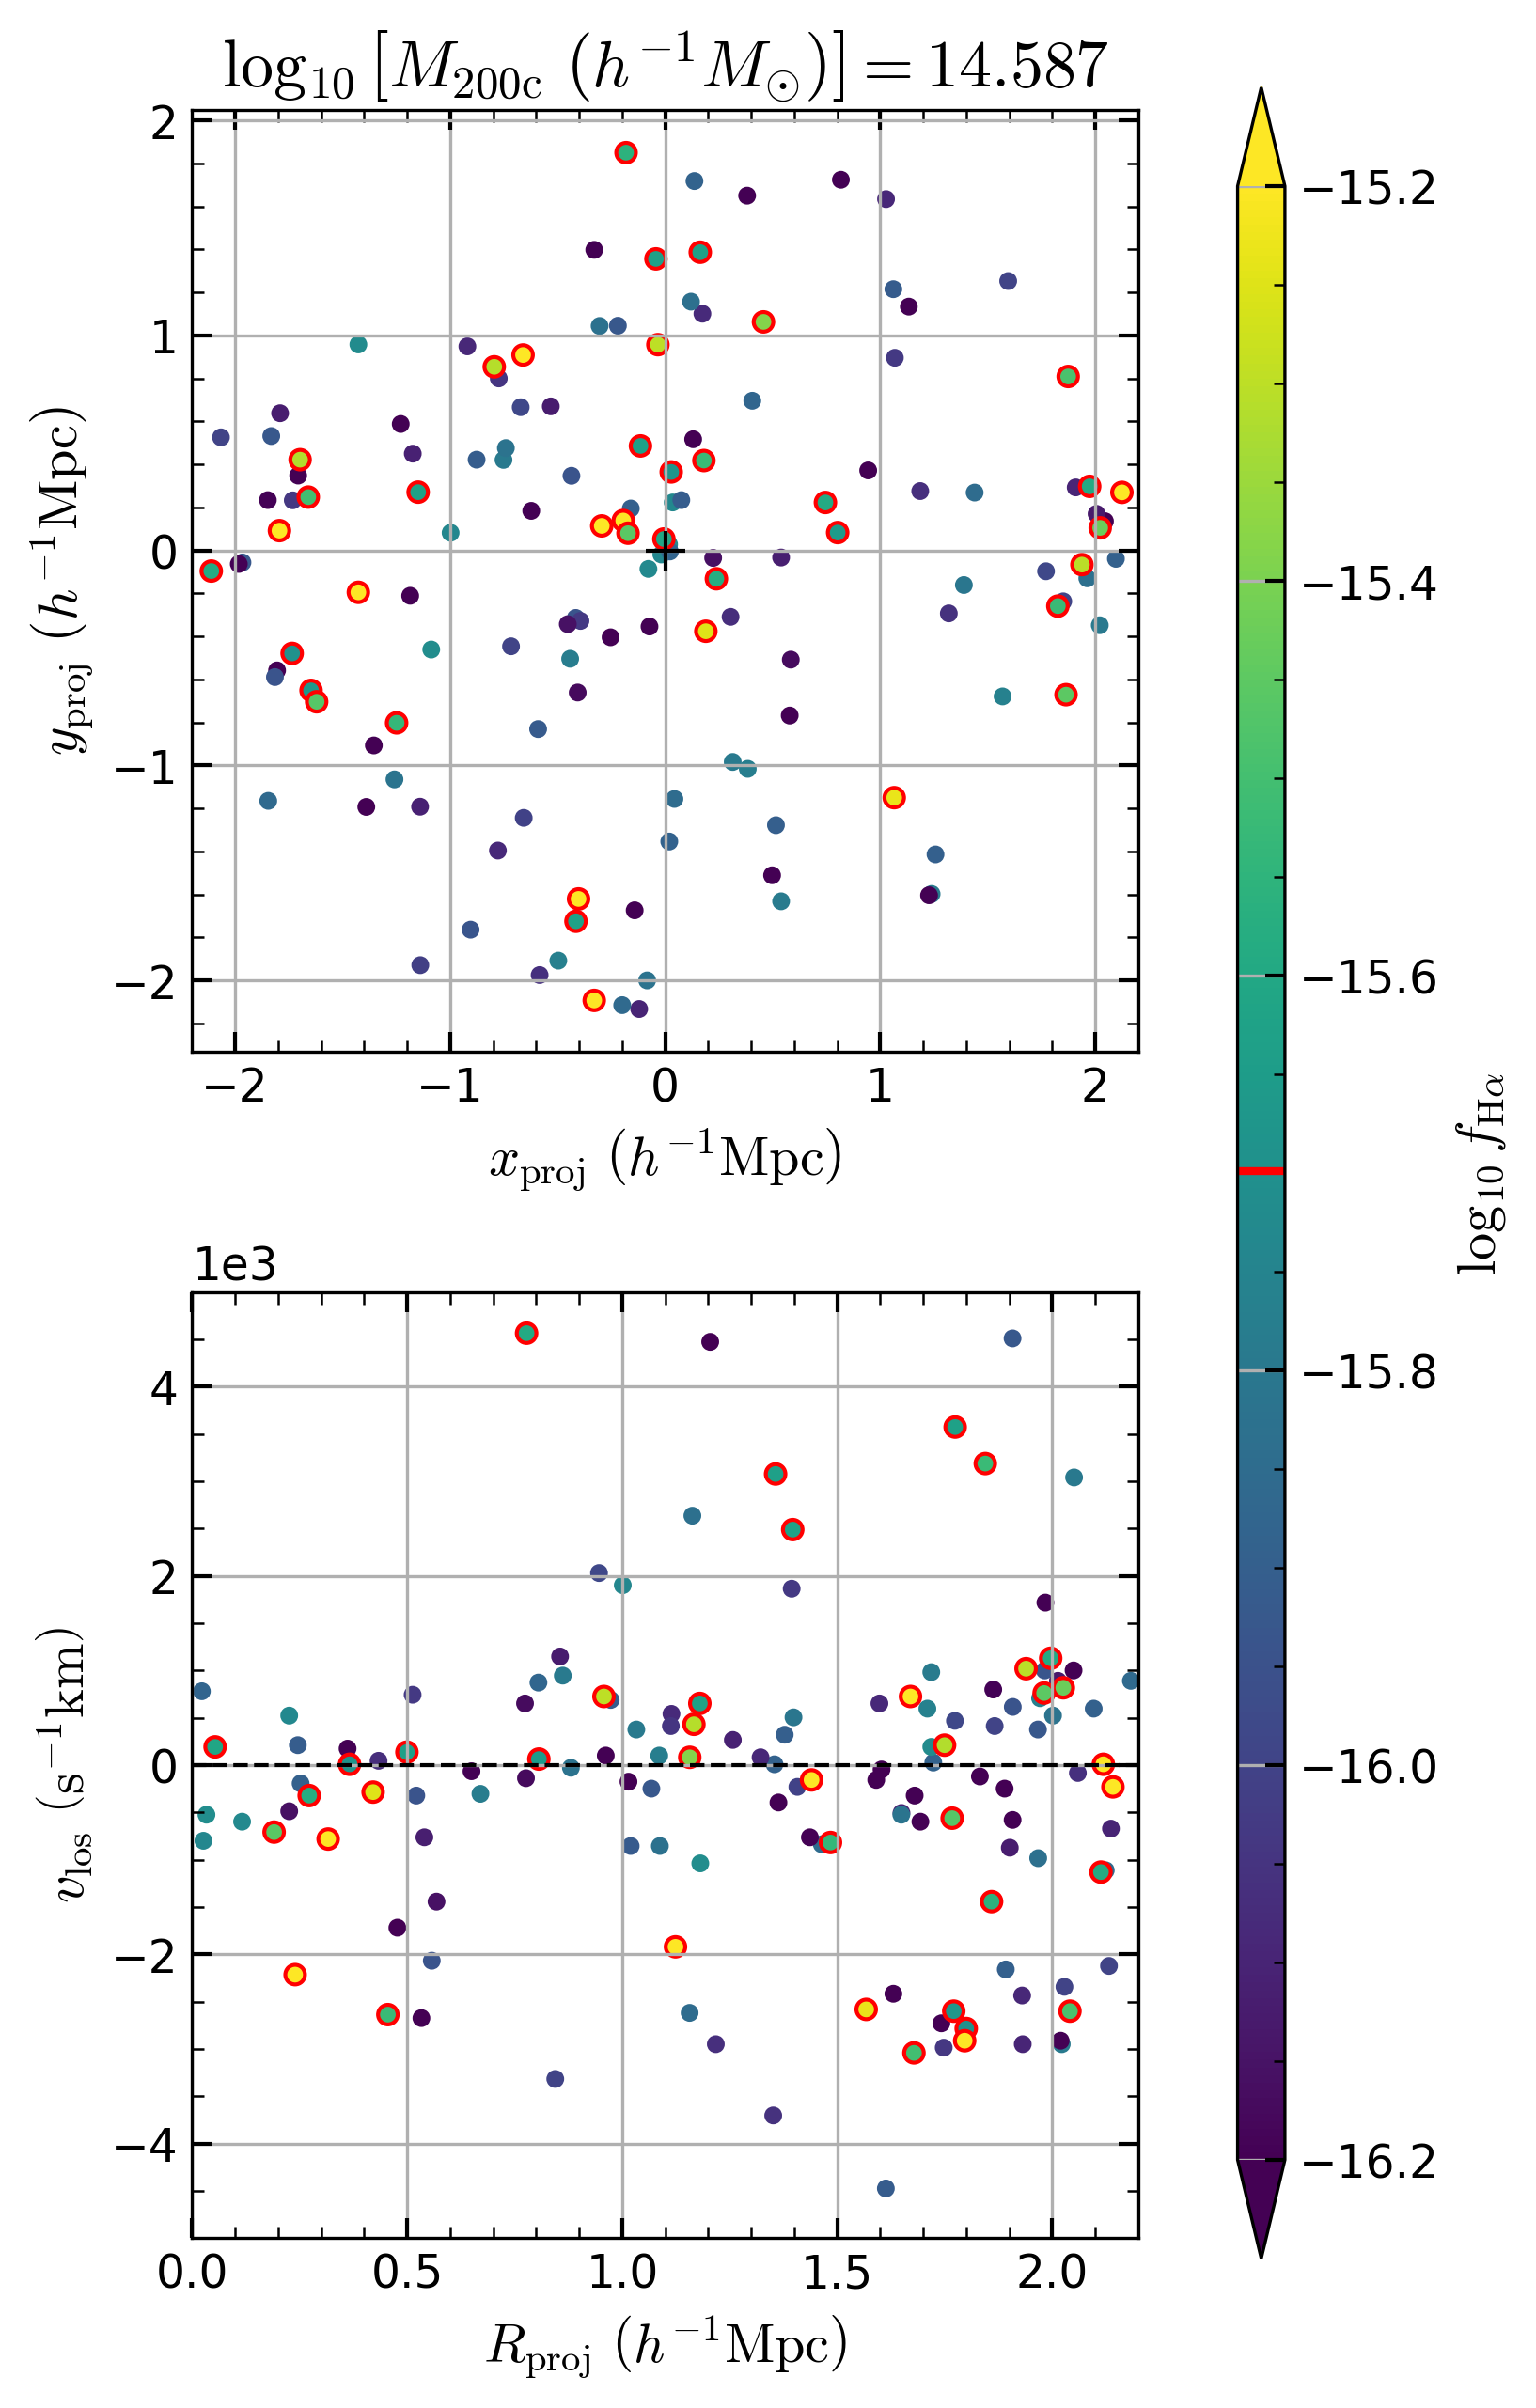

In [37]:
falpha = np.log10(2e-16)

fig = plt.figure(figsize=(5,10))
gs = mpl.gridspec.GridSpec(2,2, hspace=0.2, width_ratios=[1,0.05])
cmap, ec = 'viridis', 'red'

# sky-projected
ax = fig.add_subplot(gs[0,0])
mask = clu['fHa'] > falpha
im = ax.scatter(clu['xami'][~mask], clu['yami'][~mask], 
                marker='.', c=clu['fHa'][~mask],
                s=50,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
im = ax.scatter(clu['xami'][mask], clu['yami'][mask], 
                marker='.', c=clu['fHa'][mask],
                edgecolors=ec, lw=1., s=100,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
ax.plot(0,0, '+', c='k', ms=10)
ax.set_aspect('equal')
ax.set(xlabel=r'$x_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$y_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$')
ax.set_xlim(-2.2, 2.2)
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))
ax.set_title(r"$\log_{{10}}\left[M_{{\rm 200c}}\ \left(h^{-1}M_{\odot}\right) \right] = "
             f"{np.log10(clu['M200'].iloc[0]):.3f}$")


# dynamical
ax = fig.add_subplot(gs[1,0])
ax.axhline(0, c='k', lw=1, ls='--')
im = ax.scatter(clu['Rami'][~mask], clu['vdC100'][~mask], 
                marker='.', c=clu['fHa'][~mask],
                s=50,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
im = ax.scatter(clu['Rami'][mask], clu['vdC100'][mask], 
                marker='.', c=clu['fHa'][mask],
                edgecolors=ec, lw=1., s=100,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
ax.set(xlabel=r'$R_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$v_{\rm los}\ \left({\rm s}^{-1}{\rm km}\right)$')
xlim, ylim = (0,2.2), (-5e3, 5e3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_aspect(np.diff(xlim)/np.diff(ylim))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# colorbar
ax = fig.add_subplot(gs[:,1])
plt.colorbar(im, cax=ax, label=r'$\log_{10}f_{{\rm H}\alpha}$', extend='both')
ax.axhline(np.log10(2e-16), c='r', lw=2, ls='-')

fig.savefig('figures/dyn_ex.pdf', bbox_inches='tight')

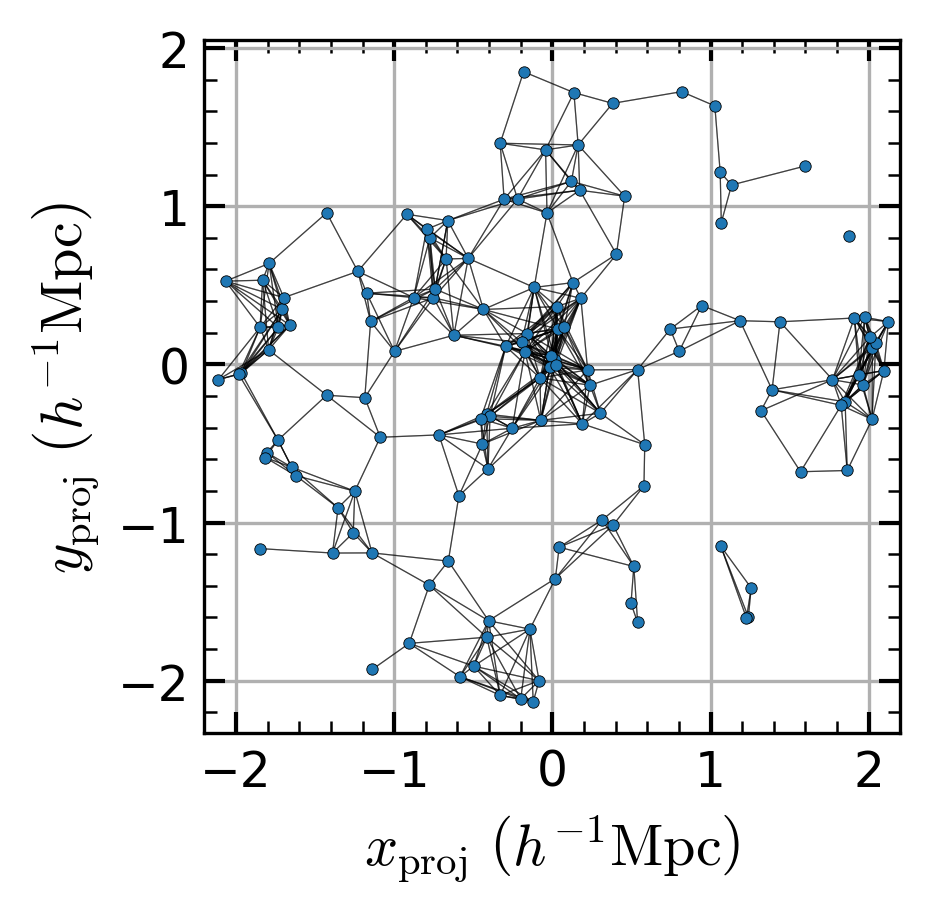

In [38]:
rmax = 0.5
graph = skn.radius_neighbors_graph(
    np.array([clu['xami'], clu['yami']]).T,
    rmax, 
    mode='distance', 
    include_self=False
).toarray()
def plot_graph(x, y, graph, ax, **kwargs):
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if graph[i,j] > 0:
                ax.plot([x[i], x[j]], [y[i], y[j]], **kwargs)

fig, axs = plt.subplots(
    1, 1, 
    figsize=(4,3),
    # gridspec_kw={'width_ratios':[1,0.05], 'wspace':0.1}
)

ax = axs  # [0]
plot_graph(clu['xami'].values, clu['yami'].values, graph, ax,
           lw=0.3, c='k', alpha=0.5, zorder=1e3)
im = ax.scatter(clu['xami'], clu['yami'], 
                marker='.', # c=clu['vdC100'],
                edgecolor='k', lw=0.2,
                s=30, vmin=-4e3, vmax=4e3,
                cmap='coolwarm', zorder=1e3)
ax.set_aspect('equal')
ax.set(xlabel=r'$x_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$y_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$')
ax.set_xlim(-2.2, 2.2)
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))

# ax = axs[1]
# plt.colorbar(
#     im, cax=ax,
#     label=r'$v_{\rm los}\ \left({\rm s}^{-1}{\rm km}\right)$')
fig.savefig('figures/graph.pdf', bbox_inches='tight')

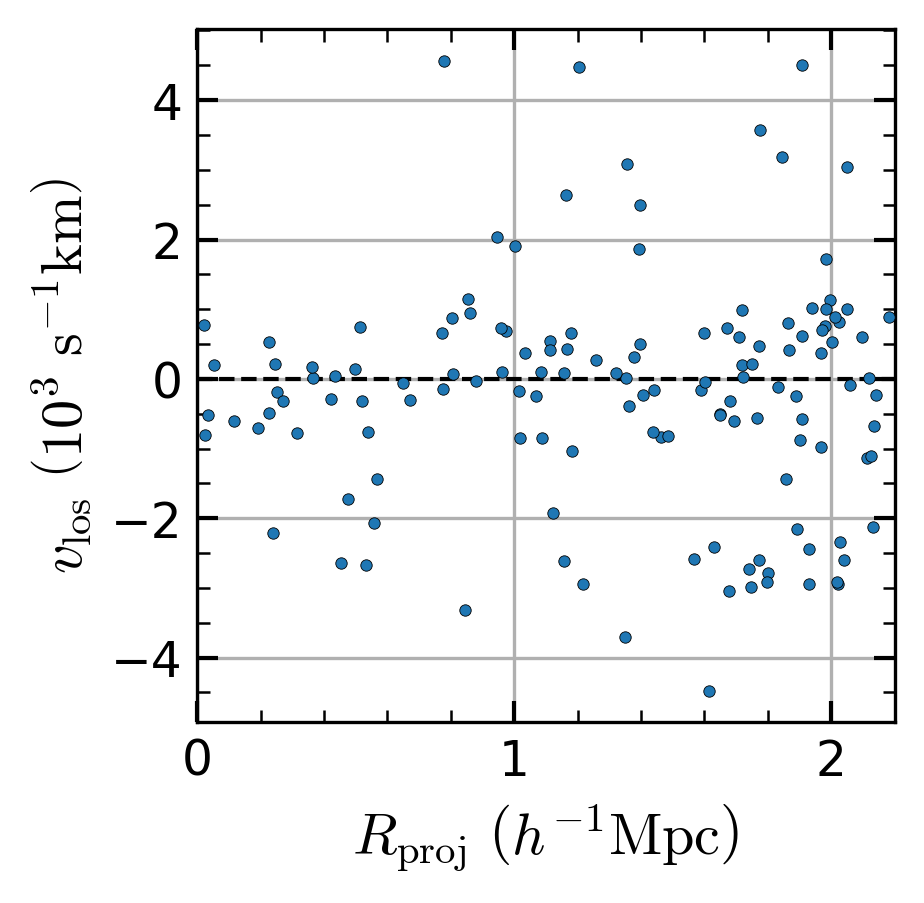

In [39]:

fig, axs = plt.subplots(
    1, 1, 
    figsize=(3,3),
)

ax = axs  
ax.axhline(0, c='k', lw=1, ls='--')
im = ax.scatter(clu['Rami'], clu['vdC100']/1e3, 
                marker='.', # c=clu['vdC100'],
                edgecolor='k', lw=0.2,
                s=30, vmin=-4e3, vmax=4e3,
                cmap='coolwarm', zorder=1e3)
# ax.set_aspect('equal')
ax.set(xlabel=r'$R_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$v_{\rm los}\ \left(10^3\ {\rm s}^{-1}{\rm km}\right)$')
ax.set_xlim(0, 2.2)
# ax.set_xticks(range(-2,3))
# ax.set_yticks(range(-2,3))

fig.savefig('figures/phasespace.pdf', bbox_inches='tight')

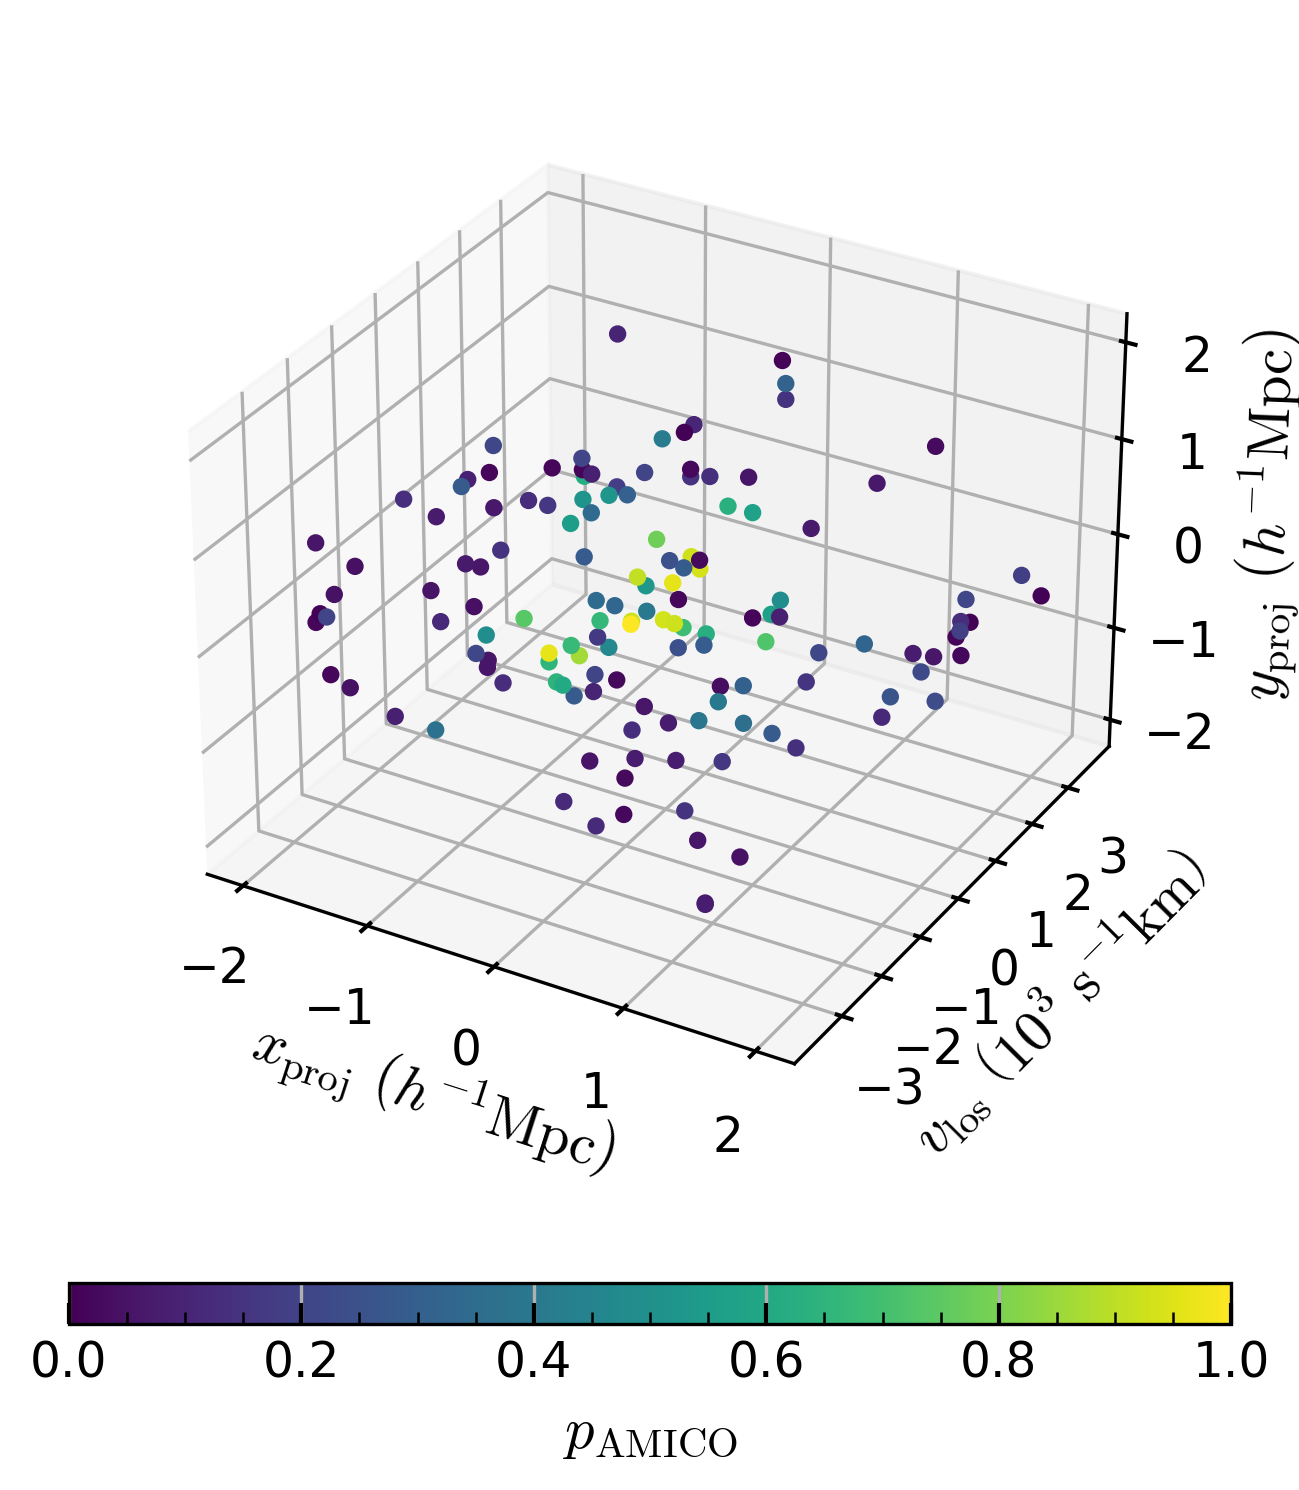

In [40]:
fig = plt.figure(figsize=(5,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.03], hspace=0.)
ax = fig.add_subplot(gs[0,0], projection='3d')
im = ax.scatter(clu['xami'], clu['vdC100']/1e3, clu['yami'],
                c=clu['Pmem'], vmin=0, vmax=1, s=10,
                alpha=1)

ax.set_box_aspect(aspect=None, zoom=0.9)
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-4, 4)
ax.set_zlim(-2.2, 2.2)
ax.set_xticks(range(-2,3))
ax.set_zticks(range(-2,3))
ax.set_yticks(np.arange(-3,4))
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)
ax.set_zticks([], minor=True)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set(xlabel=r'$x_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$v_{\rm los}\ \left({10^3\ \rm s}^{-1}{\rm km}\right)$',
       zlabel=r'$y_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',)

ax = fig.add_subplot(gs[1])
plt.colorbar(im, cax=ax, label=r'$p_{\rm AMICO}$',
             orientation='horizontal', shrink=0.9)

fig.savefig('figures/3d.pdf', bbox_inches='tight');

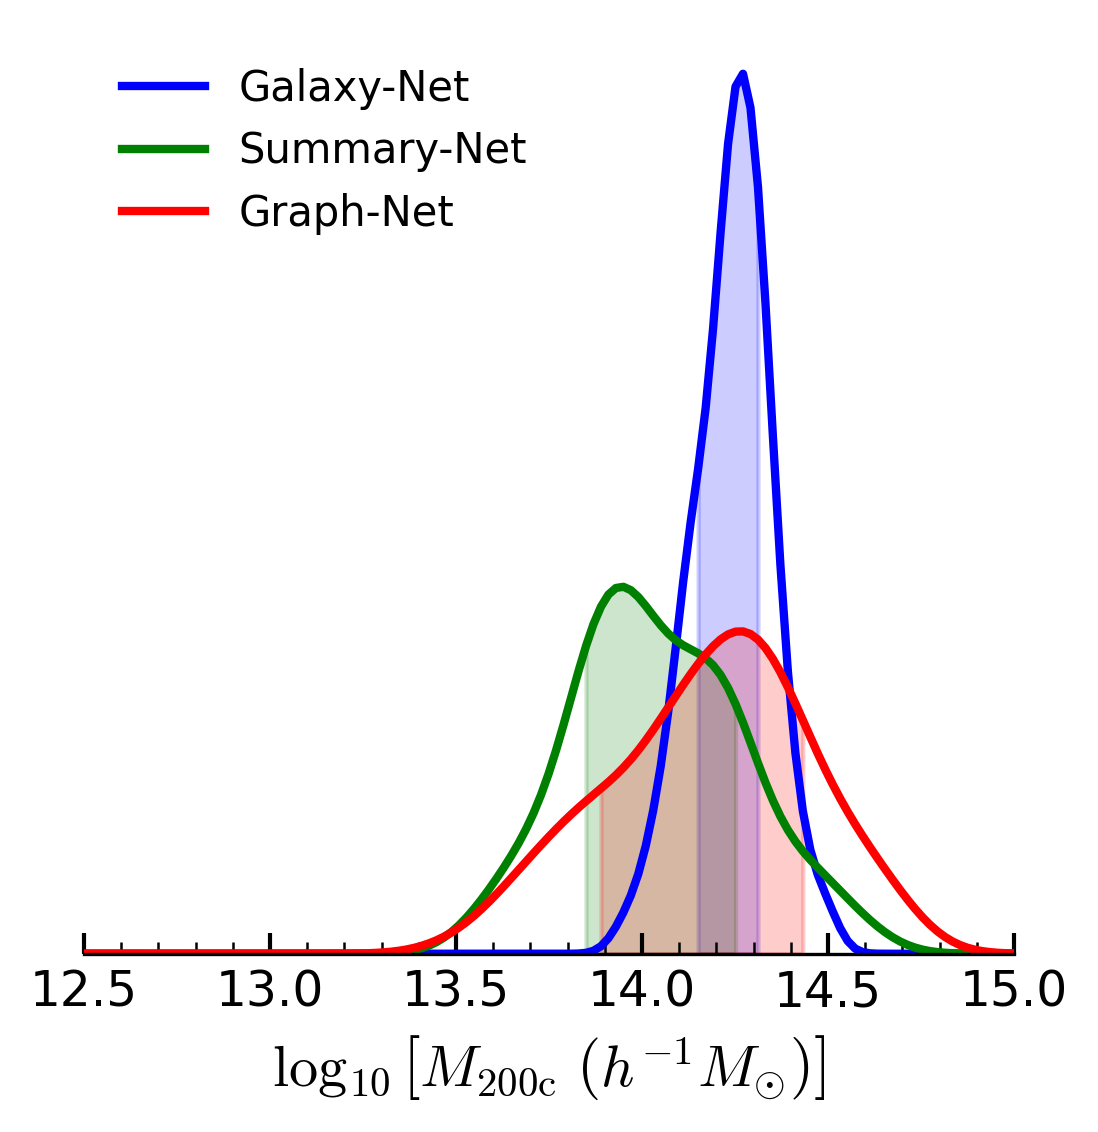

In [41]:
from scipy.stats import gaussian_kde

d = 'dC100'
mlist = ['gals_nle', 'summ_nle', 'gnn_npe']
cs = ['b','g','r']

# check all predictions are not nan
ind = idx
# flag = False
# while not flag:
#     ind = np.random.choice(len(preds[d][mlist[0]]))
    
#     flag = True
#     for m in mlist:
#         flag &= not (np.isnan(preds[d][m][ind]).any())

fig, ax = plt.subplots(figsize=(4.,4.))
x_ = np.linspace(12, 16, 200)
for i, m in enumerate(mlist):
    kde = gaussian_kde(preds[d][m][ind][...,0])
    y_ = kde.pdf(x_)
    ax.plot(x_, y_, c=cs[i], label=modeltitles[m])

    # calculate confidence interval
    p_ = np.percentile(preds[d][m][ind][...,0], q=(16,84))
    j = np.searchsorted(x_, p_)
    ax.fill_between(x_[j[0]:j[1]], [0]*(j[1]-j[0]), y_[j[0]:j[1]], 
                    color=cs[i], alpha=0.2)


leg = ax.legend(fontsize=10, frameon=False)
ax.grid(None)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', top=False)
ax.set_ylim(0)
ax.set_xlim(12.5, 15)
ax.set_xlabel(r"$\log_{{10}}\left[M_{{\rm 200c}}\ \left(h^{-1}M_{\odot}\right) \right]$")

fig.savefig('figures/posterior.pdf', bbox_inches='tight')

## Compute histogram

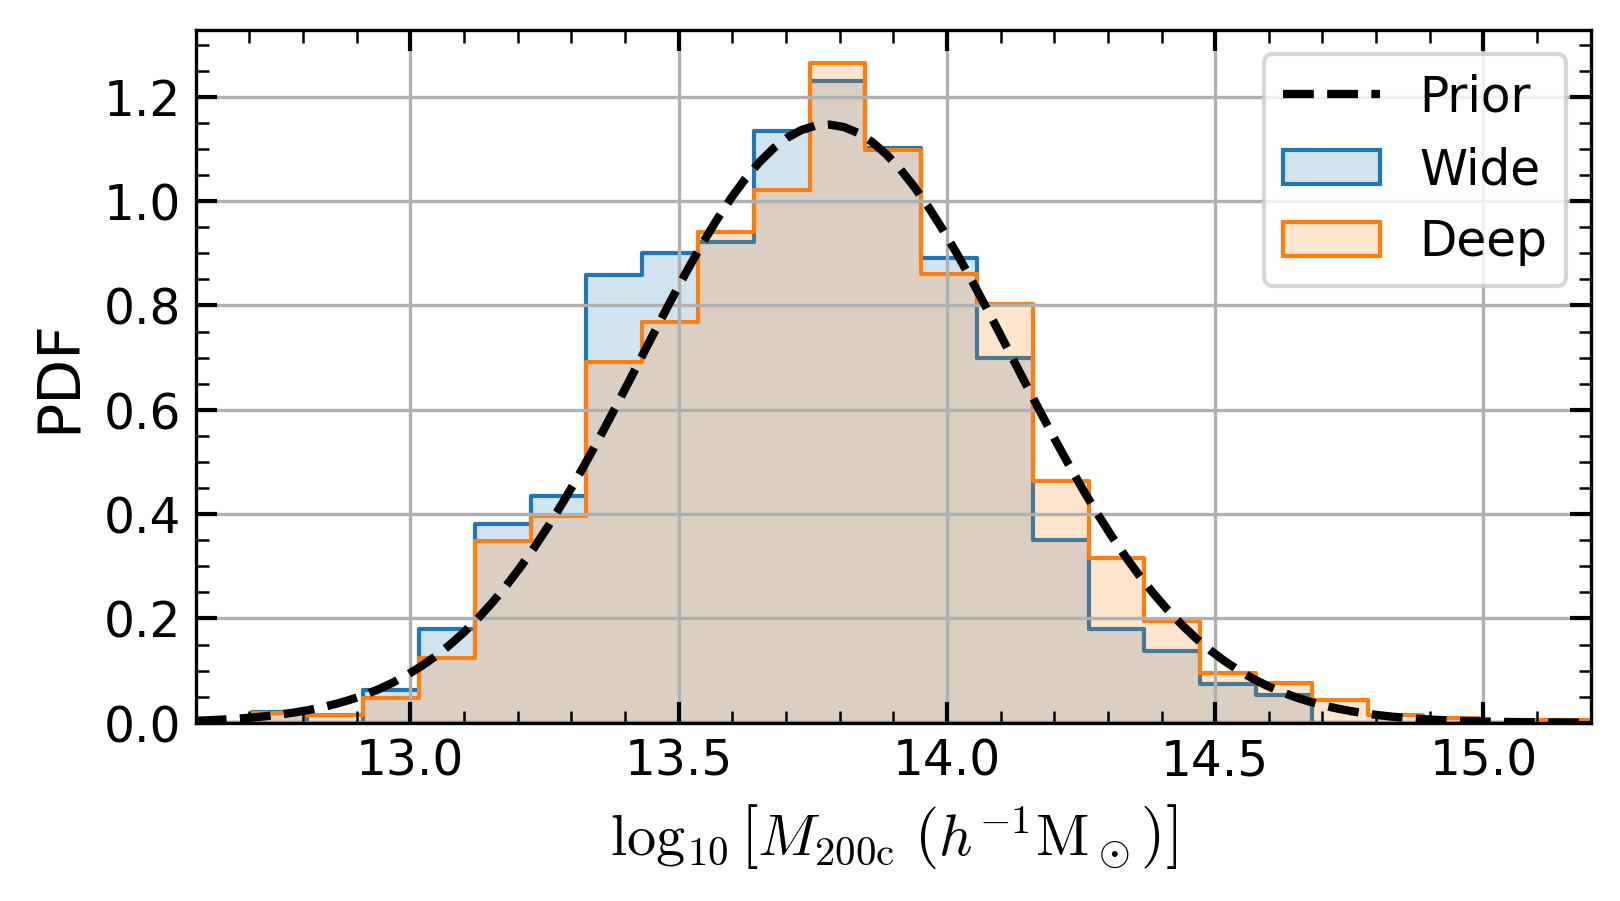

In [42]:
from scipy.stats import norm
def cen(edges):
    return (edges[:-1] + edges[1:])/2

fig, ax = plt.subplots(1, 1, figsize=(6,3))

N = 25
extent = 12.6, 15.2
x_ = np.linspace(*extent, 100)
y_ = norm.pdf(x_, loc=13.776, scale=0.3479)
ax.plot(x_, y_, 'k--', label='Prior')

data = pd.DataFrame()
for d in datanames:
    if '100' not in d:
        continue
    if d[0] == 'w':
        label = 'Wide'
    elif d[0] == 'd':
        label='Deep'
    sns.histplot(pd.DataFrame(theta[d]), x=0, bins=N, kde=False, common_norm=False,
                 alpha=0.2,  stat='density', binrange=extent,
                 label=label, element='step', ax=ax)
             
ax.set(xlabel=r'$\log_{10}\left[M_{\rm 200c}\ \left(h^{-1}{\rm M}_\odot\right)\right]$',
       ylabel='PDF')
ax.set_xlim(*extent)
ax.set_ylim(0)
ax.legend()

fig.savefig('figures/prior.pdf')

## Plot True vs. Predicted

In [127]:
xlim = min(x.min() for x in theta.values()), max(x.max() for x in theta.values())
xlim = np.array(xlim)
ylim = xlim.mean() + np.array([-1.2, 1.4])*xlim.ptp()*0.5

rlim = 1, 100  # richness limits
rlim = np.log10(rlim)

def sample_even(x, N, bins=40):
    # sample from x to form a uniform distribution
    ind = np.digitize(x, np.linspace(*xlim, bins+1))
    to_choose = []
    for i in range(1, bins+1):
        binx = np.argwhere(ind == i).flatten()
        to_choose.append(
            np.random.choice(binx, min(len(binx), N//bins+1), replace=False)
        )
    to_choose = np.concatenate(to_choose)
    mask = np.zeros(len(x), dtype=bool)
    mask[to_choose] = True
    return mask

def quality_control(percs):
    med = percs[2]
    mask = (med > 12) & (med < 16)

    err = (percs[1] - percs[0])/2
    mask &= err < 1
    return mask

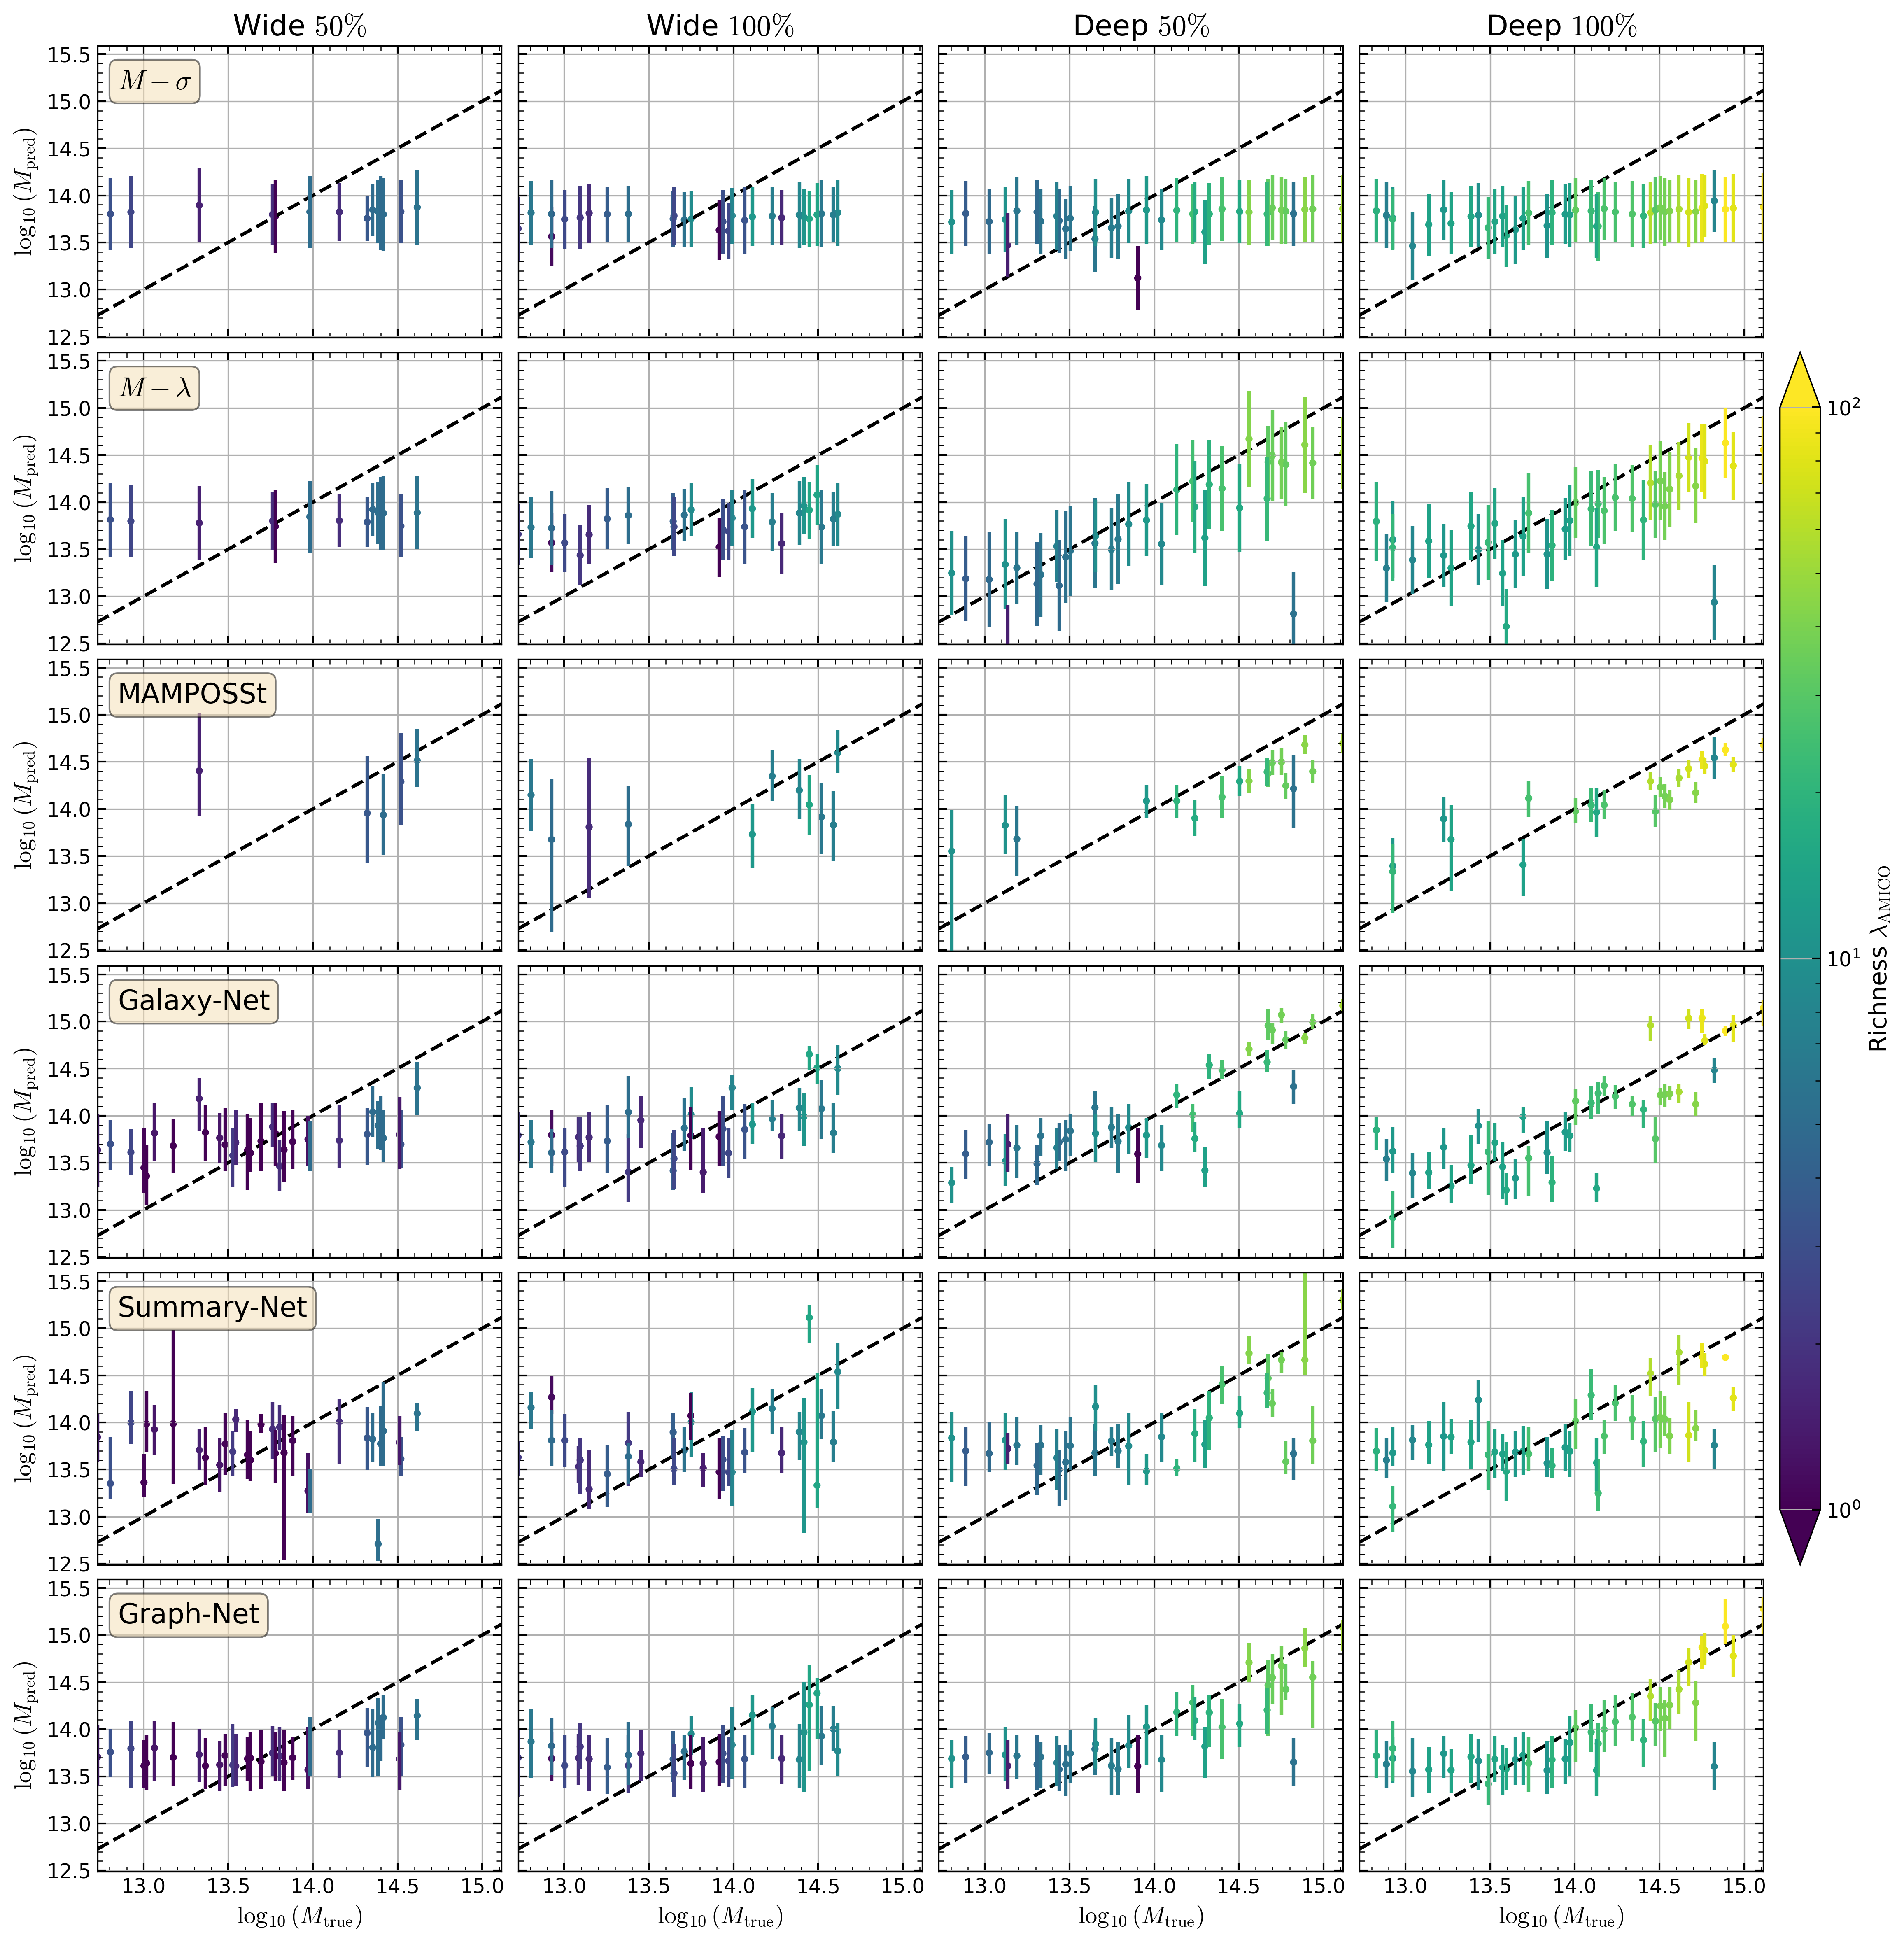

In [130]:

W, H = len(datanames), len(modelnames)
to_plot =  50
np.random.seed(0)

fig = plt.figure(figsize=(W*4.5, H*3.2))
gs = fig.add_gridspec(H, W+1, width_ratios=[1]*W+[0.1], wspace=0.05, hspace=0.05)

cmap = plt.cm.get_cmap('viridis')
for i, d in enumerate(datanames):
    mask = sample_even(theta[d], to_plot)
    _r = np.log10(richs[d])
    _c = cmap((_r-rlim[0])/rlim.ptp())
    _y = theta[d][mask]
    _c = _c[mask]

    for j, m in enumerate(modelnames):
        ax = fig.add_subplot(gs[j, i])#, aspect='equal')
        if j==0:
            ax.set_title(datatitles[d])
        if m not in percs[d]:  # skip if model not available
            ax.axis('off')
            continue

        # quality control
        _p = percs[d][m][:,mask]
        qcmask = quality_control(_p)
        _p = _p[:,qcmask]
        med = _p[2]
        err = np.abs(_p[:2] - med)
        ytr = _y[qcmask]
        col = _c[qcmask]

        ax.plot(xlim, xlim, 'k--')
        ax.errorbar(
            ytr, med, 
            yerr=err, 
            fmt='none', ecolor=col
        )
        ax.scatter(ytr, med, marker='.', c=col, s=40)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        if i==0:
            ax.set_ylabel('$\log_{10}(M_{\\rm pred})$')
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.85, modeltitles[m], 
                    fontsize=16, transform=ax.transAxes, bbox=props)
        else:
            ax.set_yticklabels([])
        if j==H-1:
            ax.set_xlabel('$\log_{10}(M_{\\rm true})$')
        else:
            ax.set_xticklabels([])
ax = fig.add_subplot(gs[1:-1, -1])
norm = mcolors.LogNorm(vmin=10**rlim[0], vmax=10**rlim[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=ax, label='Richness $\lambda_{\\rm AMICO}$', extend='both')
fig.savefig('figures/true_vs_pred.pdf', bbox_inches='tight');

## Create comparison table

In [139]:
from scipy.stats import norm, spearmanr

# richmin = 20
def calc_row(true, perc, rich):
    med = perc[2]
    err = np.nanmean(np.abs(perc[2] - perc[:2]), axis=0)

    # quality control
    mask = quality_control(perc)
    true, med, err, rich = true[mask], med[mask], err[mask], rich[mask]

    out = []
    # stdtot
    out += [np.nanstd(true - med)]

    # # std10
    # mask = rich >= richmin
    # if np.sum(~np.isnan(med[mask])) > 0:
    #     out += [np.nanstd(true[mask] - med[mask])]
    # else:
    #     out += [np.nan]

    # rs
    out += [spearmanr(true, med)[0]]

    # log-likelihood
    loglik = norm.logpdf(x=med, loc=true, scale=err)
    loglik = np.nanmean(loglik)
    out += [loglik]

    return out

out = []
for m in modelnames:
    out += [[]]
    for d in datanames:
        if m in percs[d].keys():
            out[-1] += [calc_row(theta[d][:,0], percs[d][m], richs[d])]
        else:
            out[-1] += [[np.nan]*3]

out = np.array(out)  # (Nmodels, Ndata, Nmetrics)

# # temp
# b = [np.nanargmin(out[..., i, 1], axis=0) 
#      if (not np.all(np.isnan(out[..., i, 1]))) else -1
#      for i in range(out.shape[1])]

best = np.stack([
    np.nanargmin(out[...,0], axis=0),  # stdtot
    np.nanargmax(out[...,1], axis=0),  # rs
    np.nanargmax(out[...,2], axis=0),  # logL
], axis=0)  # (Nmetrics, Ndata)

for i, m in enumerate(modelnames):
    s = f"{modeltitles[m]} & "
    for j in range(out.shape[1]):
        for k, v in enumerate(out[i,j]):
            if np.isnan(v):
                s += ' - '
            elif best[k,j] == i:
                s += f"\\textbf{{{v:.3f}}}"
            else:
                s += f"{v:.3f}"
            s += ' & '
    print(s[:-2] + '\\\\')

$M-\sigma$ & 0.333 & 0.123 & -0.301 & 0.325 & 0.154 & -0.291 & 0.341 & 0.210 & -0.341 & 0.337 & 0.254 & -0.329 \\
$M-\lambda$ & 0.332 & 0.121 & -0.296 & 0.327 & 0.218 & -0.295 & 0.409 & 0.448 & -0.693 & 0.367 & 0.482 & -0.443 \\
MAMPOSSt & 0.419 & 0.069 & -0.632 & 0.432 & 0.150 & -0.651 & 0.370 & 0.392 & -0.741 & 0.354 & 0.464 & -1.265 \\
Galaxy-Net & 0.326 & 0.224 & -0.349 & 0.329 & 0.266 & -0.409 & 0.341 & 0.432 & -0.911 & 0.362 & 0.448 & -1.646 \\
Summary-Net & 0.396 & 0.126 & -0.932 & 0.383 & 0.202 & -0.837 & 0.364 & 0.340 & -1.067 & 0.360 & 0.342 & -1.020 \\
Graph-Net & \textbf{0.317} & \textbf{0.245} & \textbf{-0.283} & \textbf{0.310} & \textbf{0.269} & \textbf{-0.265} & \textbf{0.297} & \textbf{0.464} & \textbf{-0.228} & \textbf{0.287} & \textbf{0.514} & \textbf{-0.196} \\


## Scatter vs Richness, Redshift

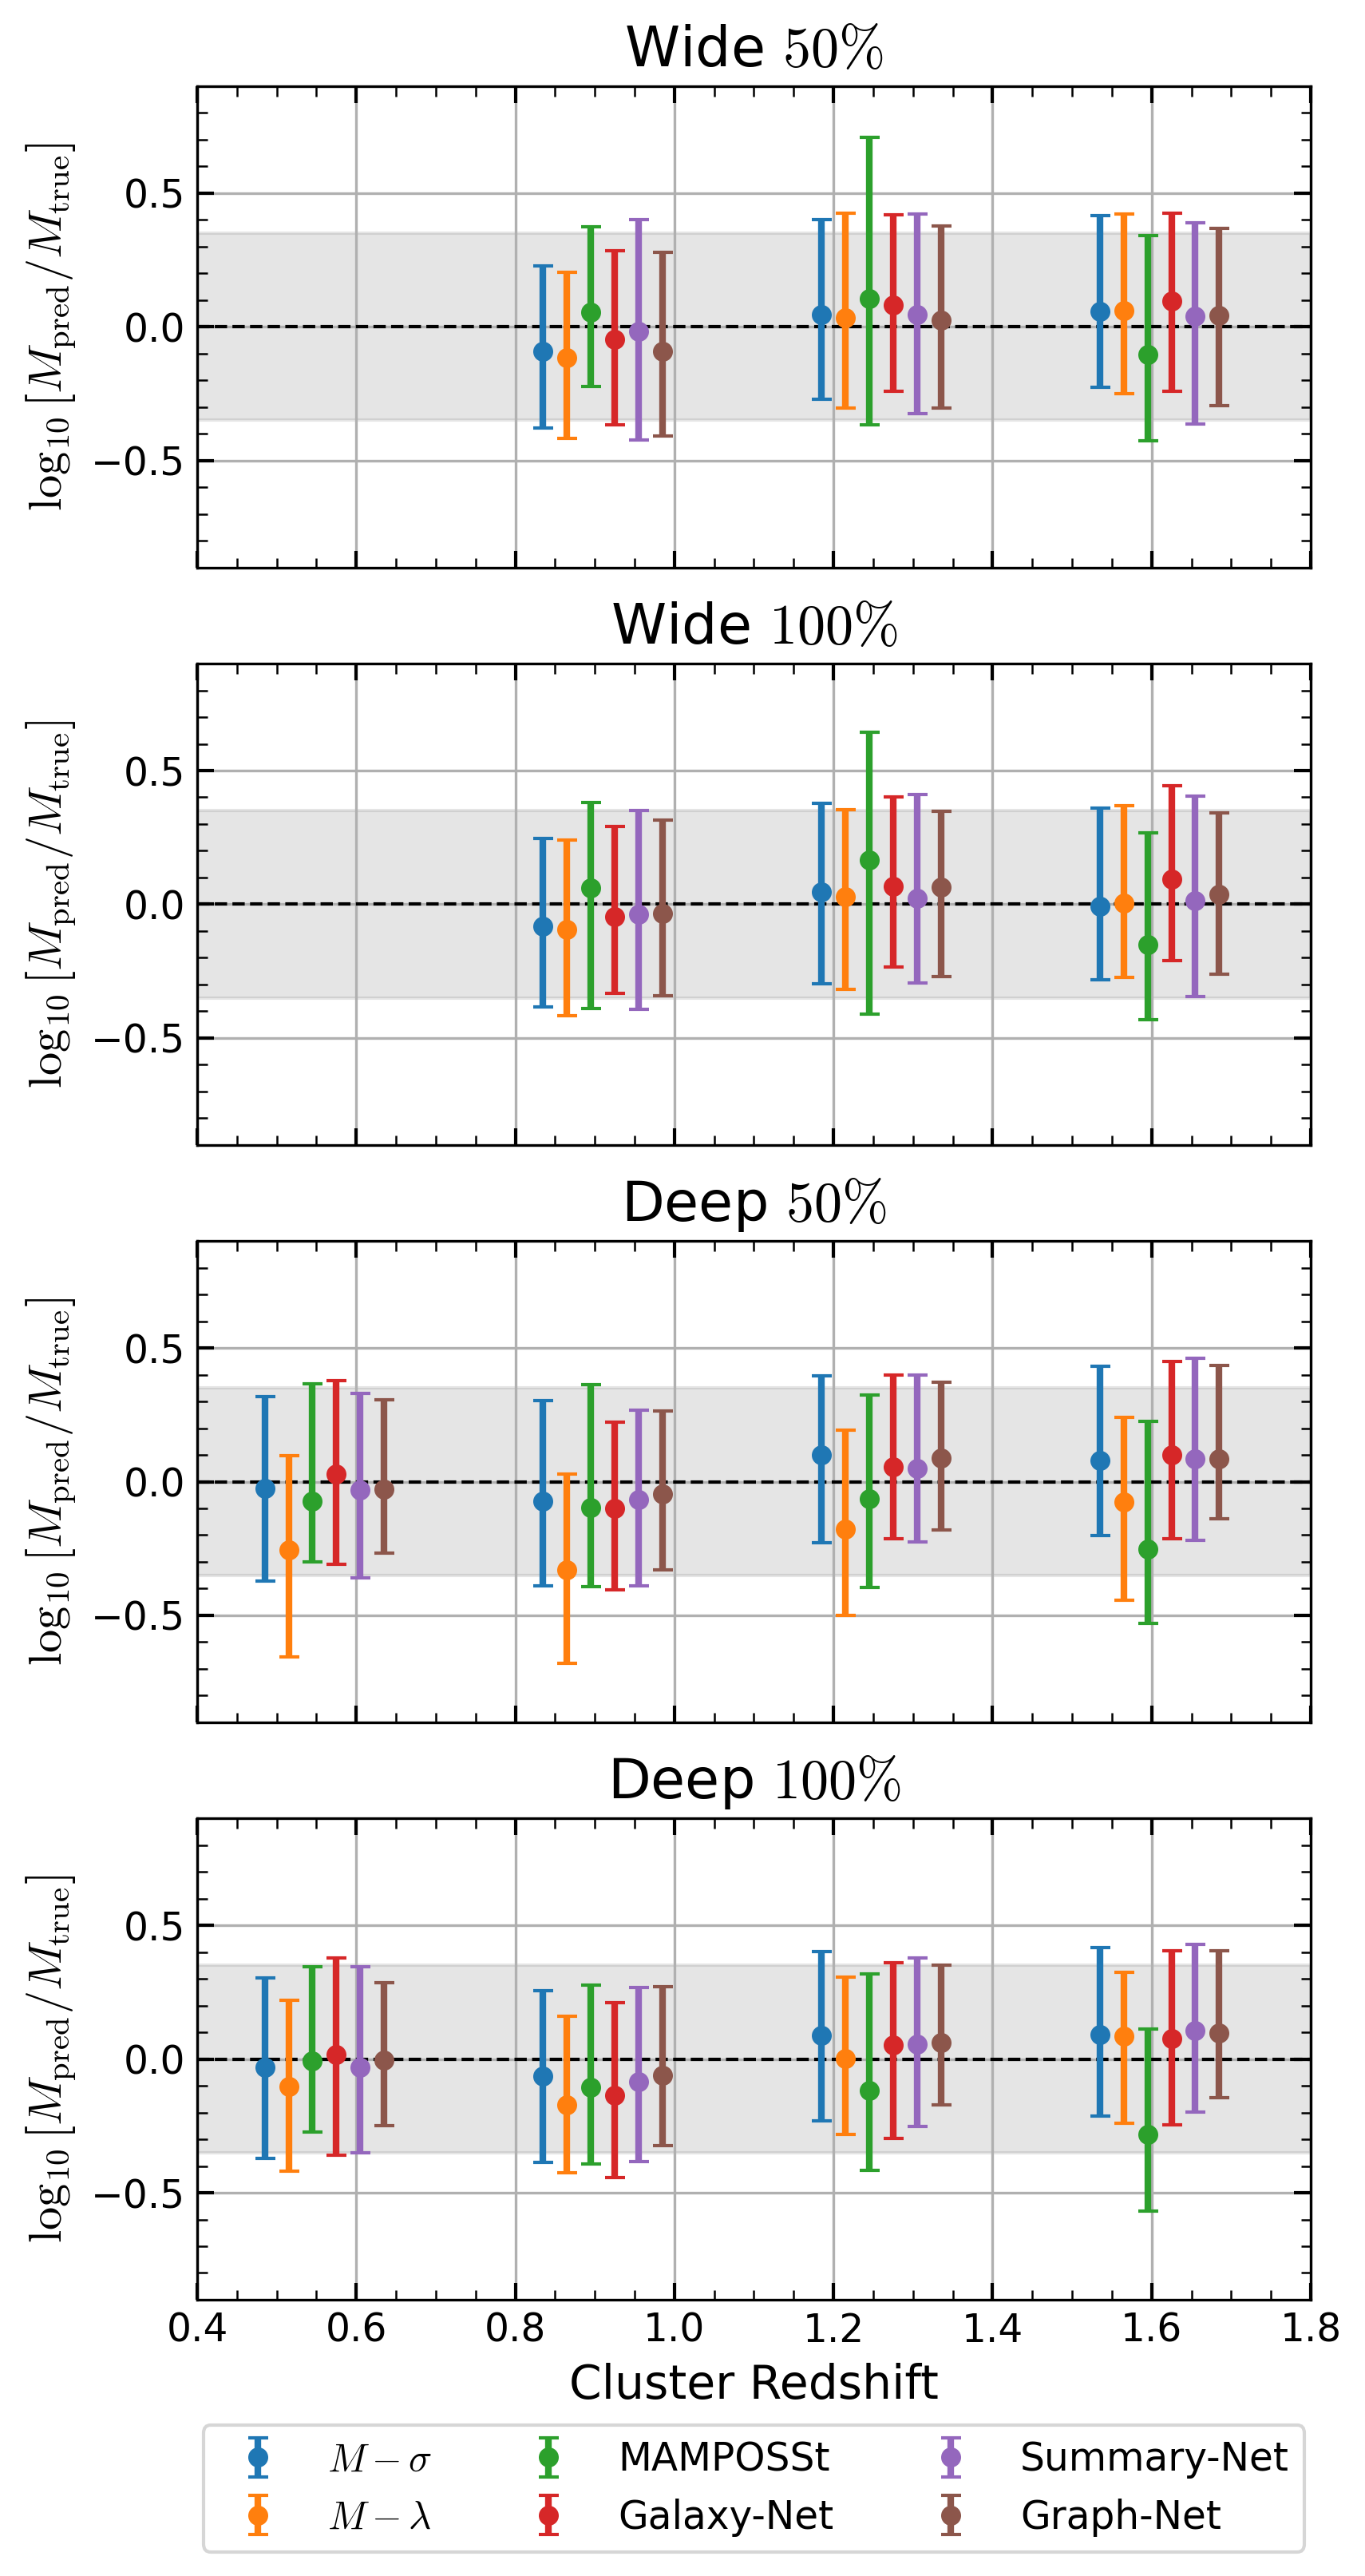

In [159]:

# Redshift-dependence

H, W = len(datanames), 1
f, axs = plt.subplots(H, W, figsize=(W*6, H*3), sharex=True, sharey=True,
                      gridspec_kw={'hspace':0.2})
axs = axs.flatten()
bin_edges = np.linspace(0.4, 1.8, 5)
dx = 0.03

for j, d in enumerate(datanames):
    ax = axs[j]
    ax.axhline(0, c='k', lw=1, ls='--')  # midline
    ax.fill_between([0.4, 1.8], -0.35, 0.35, color=f'gray', 
                    alpha=0.2)  # prior
    for i, m in enumerate(modelnames):
        if m not in percs[d]:
            continue
        # ax.semilogx()
        _r = zclus[d]
        _p = percs[d][m][2] -  theta[d][:,0]  # median error

        # quality control
        qcmask = quality_control(percs[d][m])
        _r, _p = _r[qcmask], _p[qcmask]

        argbin = np.digitize(_r, bin_edges)
        for b in range(1, len(bin_edges)):
            mask = argbin == b
            if np.sum(mask) == 0:
                continue
            __p = np.percentile(_p[mask], q=[16,50,84])
            med = __p[1]
            _x = np.mean(bin_edges[b-1:b+1]) + dx*(i - len(modelnames)/2)
            errbar = np.array([__p[1]-__p[0], __p[2]-__p[1]])[:,None]
            ax.errorbar(
                _x, med, yerr=errbar, fmt='.', capsize=3, ms=10,
                color=f'C{i}', label=modeltitles[m] if b==1 else None
            )
        ax.set_title(datatitles[d])
        ax.set_xlim(0.4, 1.8)
        ax.set_ylim(-0.9, 0.9)
        ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/M_{\rm true}\right]$')
# # Organize the legend handles
# handles, labels = ax.get_legend_handles_labels()
# handles = handles[1:] + handles[:1]
# labels = labels[1:] + labels[:1]

# Create the legend
axs[-1].legend(
    ncols=3, bbox_to_anchor=(0.5, -0.22),
    loc='upper center')
axs[-1].set_xlabel('Cluster Redshift')

# Save
f.savefig('figures/redshift_dependence.pdf', bbox_inches='tight');

In [154]:
print('Count in each redshift bin:')
for d in datanames:
    print(np.histogram(zclus[d], bins=bin_edges)[0])

Count in each redshift bin:
[  0 304 346 190]
[  0 317 371 219]
[793 603 368 234]
[808 602 370 234]


wC50
wC100


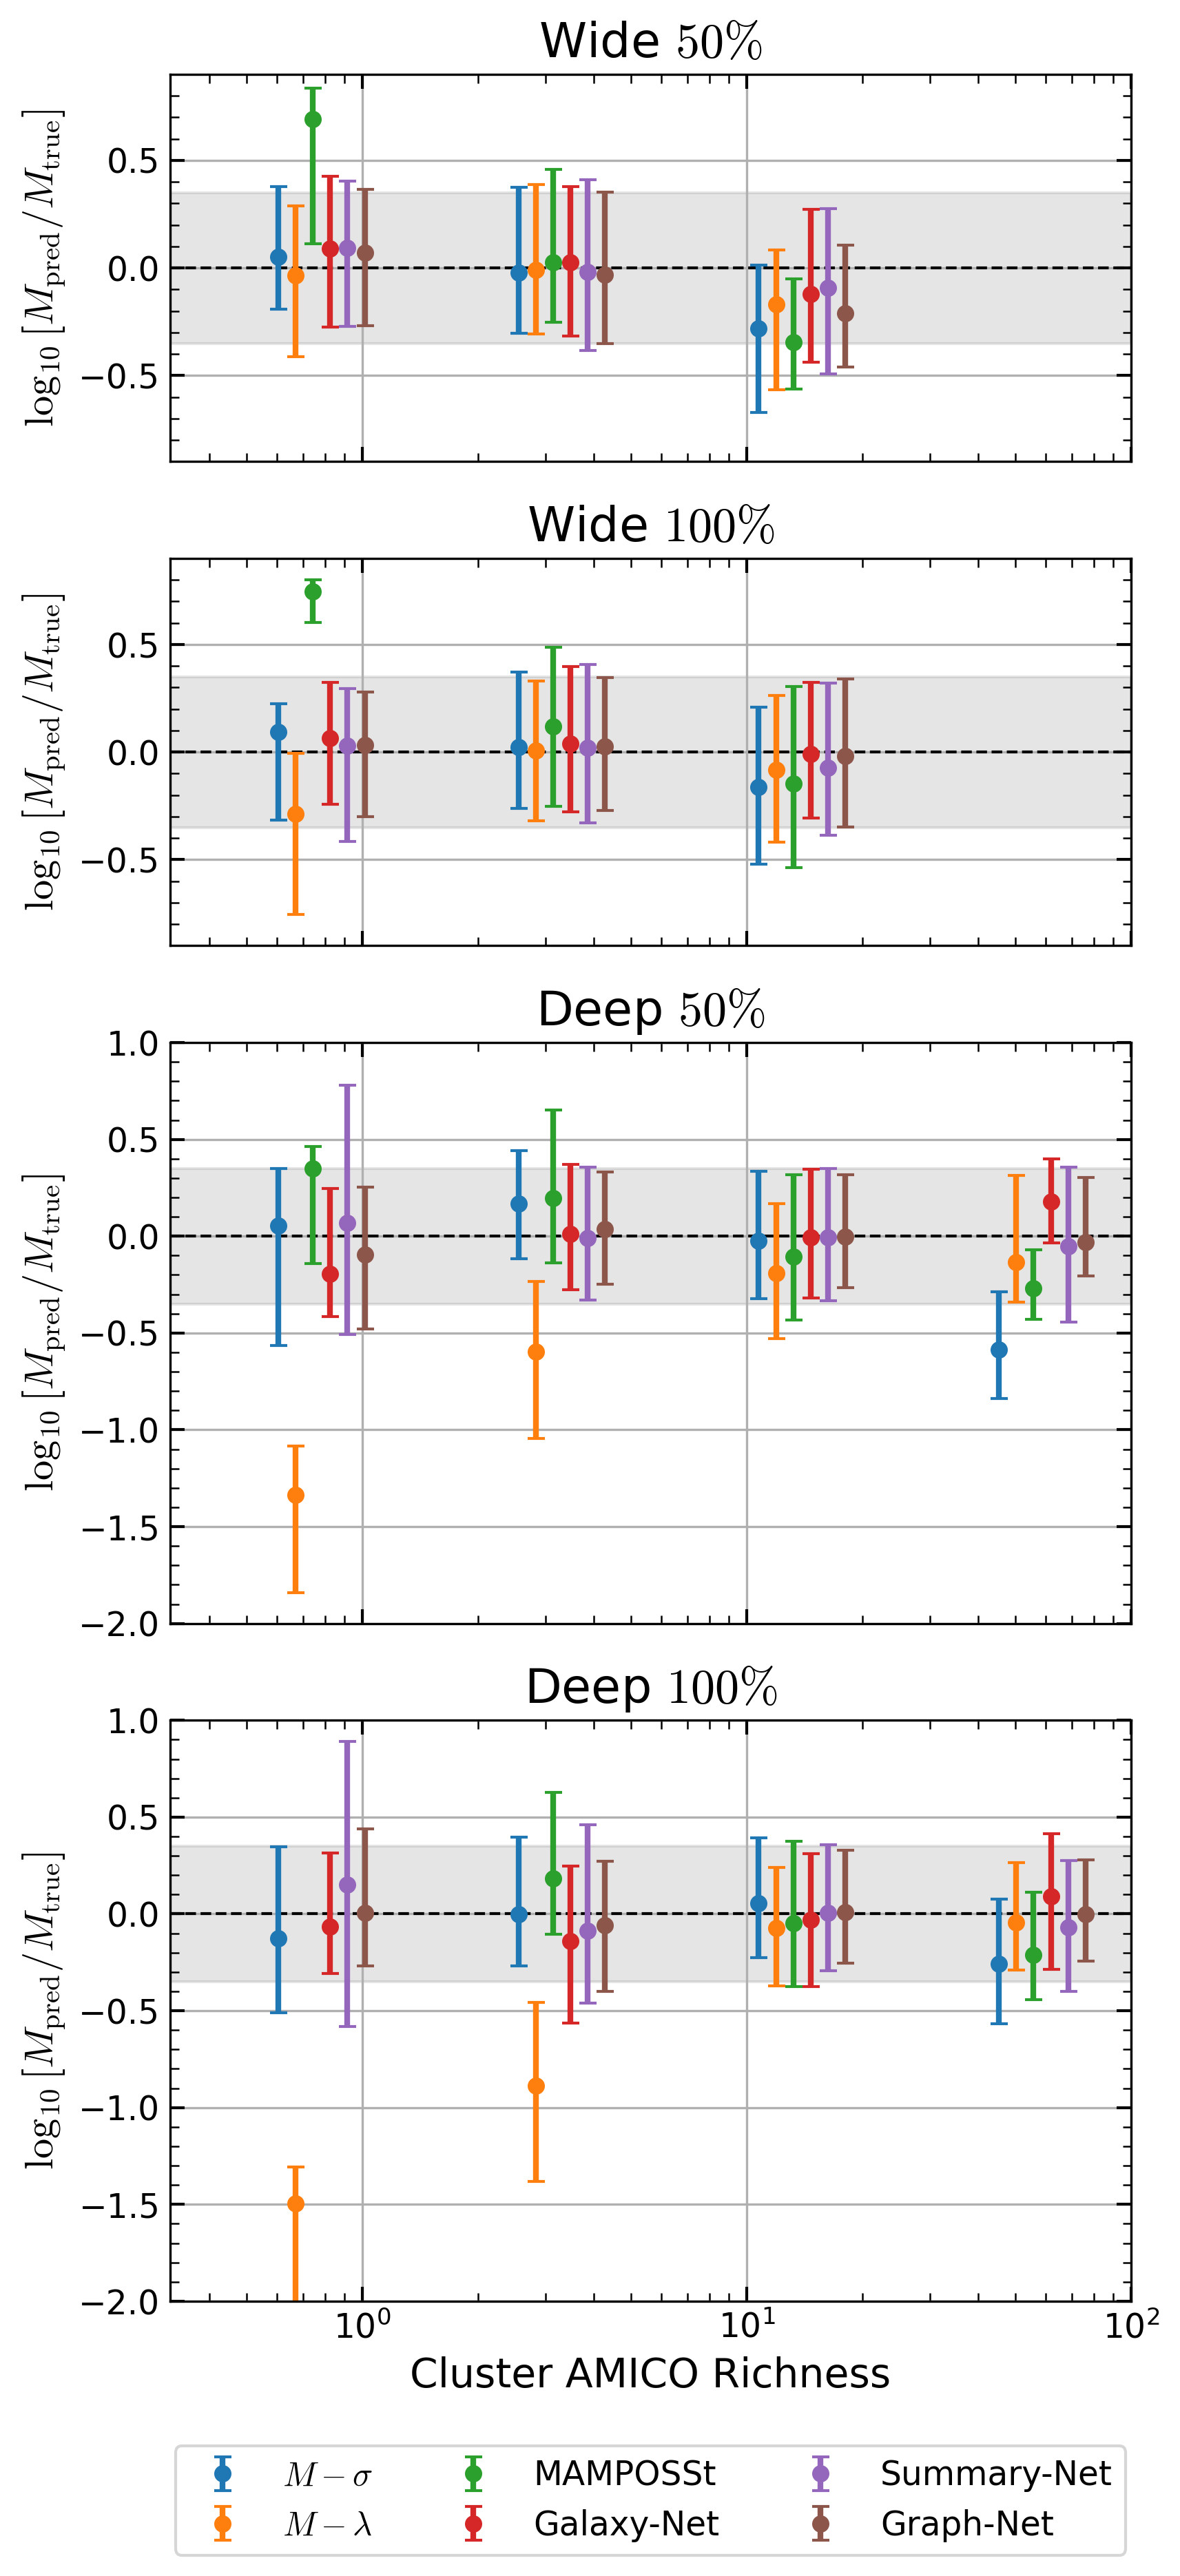

In [169]:
# Richness-dependence

H, W = len(datanames), 1
f, axs = plt.subplots(H, W, figsize=(W*6, H*3.5), sharex=True,
                      gridspec_kw={'hspace':0.2, 'wspace':0.1,
                                   'height_ratios': [2,2,3,3]})
axs = axs.flatten()
bin_edges = np.logspace(-0.5, 2, 5)
dx = 0.045

for j, d in enumerate(datanames):
    ax = axs[j]
    ax.semilogx()
    ax.axhline(0, c='k', lw=1, ls='--')  # midline
    ax.fill_between(bin_edges[[0,-1]], -0.35, 0.35, color=f'gray', 
                    alpha=0.2)  # prior
    for i, m in enumerate(modelnames):
        if m not in percs[d]:
            continue
        _r = richs[d]
        _p = (percs[d][m][2] - theta[d][:,0])  # median error
        mask = quality_control(percs[d][m])
        _r, _p = _r[mask], _p[mask]

        argbin = np.digitize(_r, bin_edges)
        for b in range(1, len(bin_edges)):
            mask = argbin == b
            if np.sum(mask) <= 1:
                continue
            __p = np.percentile(_p[mask], q=[16,50,84])
            med = __p[1]
            _x = np.mean(bin_edges[b-1:b+1])*10**(dx*(i - len(modelnames)/2))
            errbar = np.array([__p[1]-__p[0], __p[2]-__p[1]])[:,None]
            ax.errorbar(
                _x, med, yerr=errbar, fmt='.', capsize=3, ms=10,
                color=f'C{i}', label=modeltitles[m] if b==2 else None
            )
    ax.set_title(datatitles[d])
    ax.set_xlim(bin_edges[0], bin_edges[-1])
    ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/M_{\rm true}\right]$')
    
    if d[0]=='w':
        print(d)
        ax.set_ylim(-0.9, 0.9)
    else:
        ax.set_ylim(-2, 1.)


# Create the legend
axs[-1].legend(
    ncols=3, bbox_to_anchor=(0.5, -0.22), 
    loc='upper center')
axs[-1].set_xlabel('Cluster AMICO Richness')

# Save
f.savefig('figures/richness_dependence.pdf', bbox_inches='tight');

In [170]:
np.log10bin_edges

array([  0.31622777,   1.33352143,   5.62341325,  23.71373706,
       100.        ])

In [126]:
print('Count in each richness bin:')
for d in datanames:
    print(np.histogram(richs[d], bins=bin_edges)[0])

Count in each richness bin:
[204 569  24   0]
[ 48 681 170   0]
[  36  316 1583   61]
[  14   77 1454  464]


In [172]:
1454/(1454+464)

0.7580813347236705

## Coverage plots

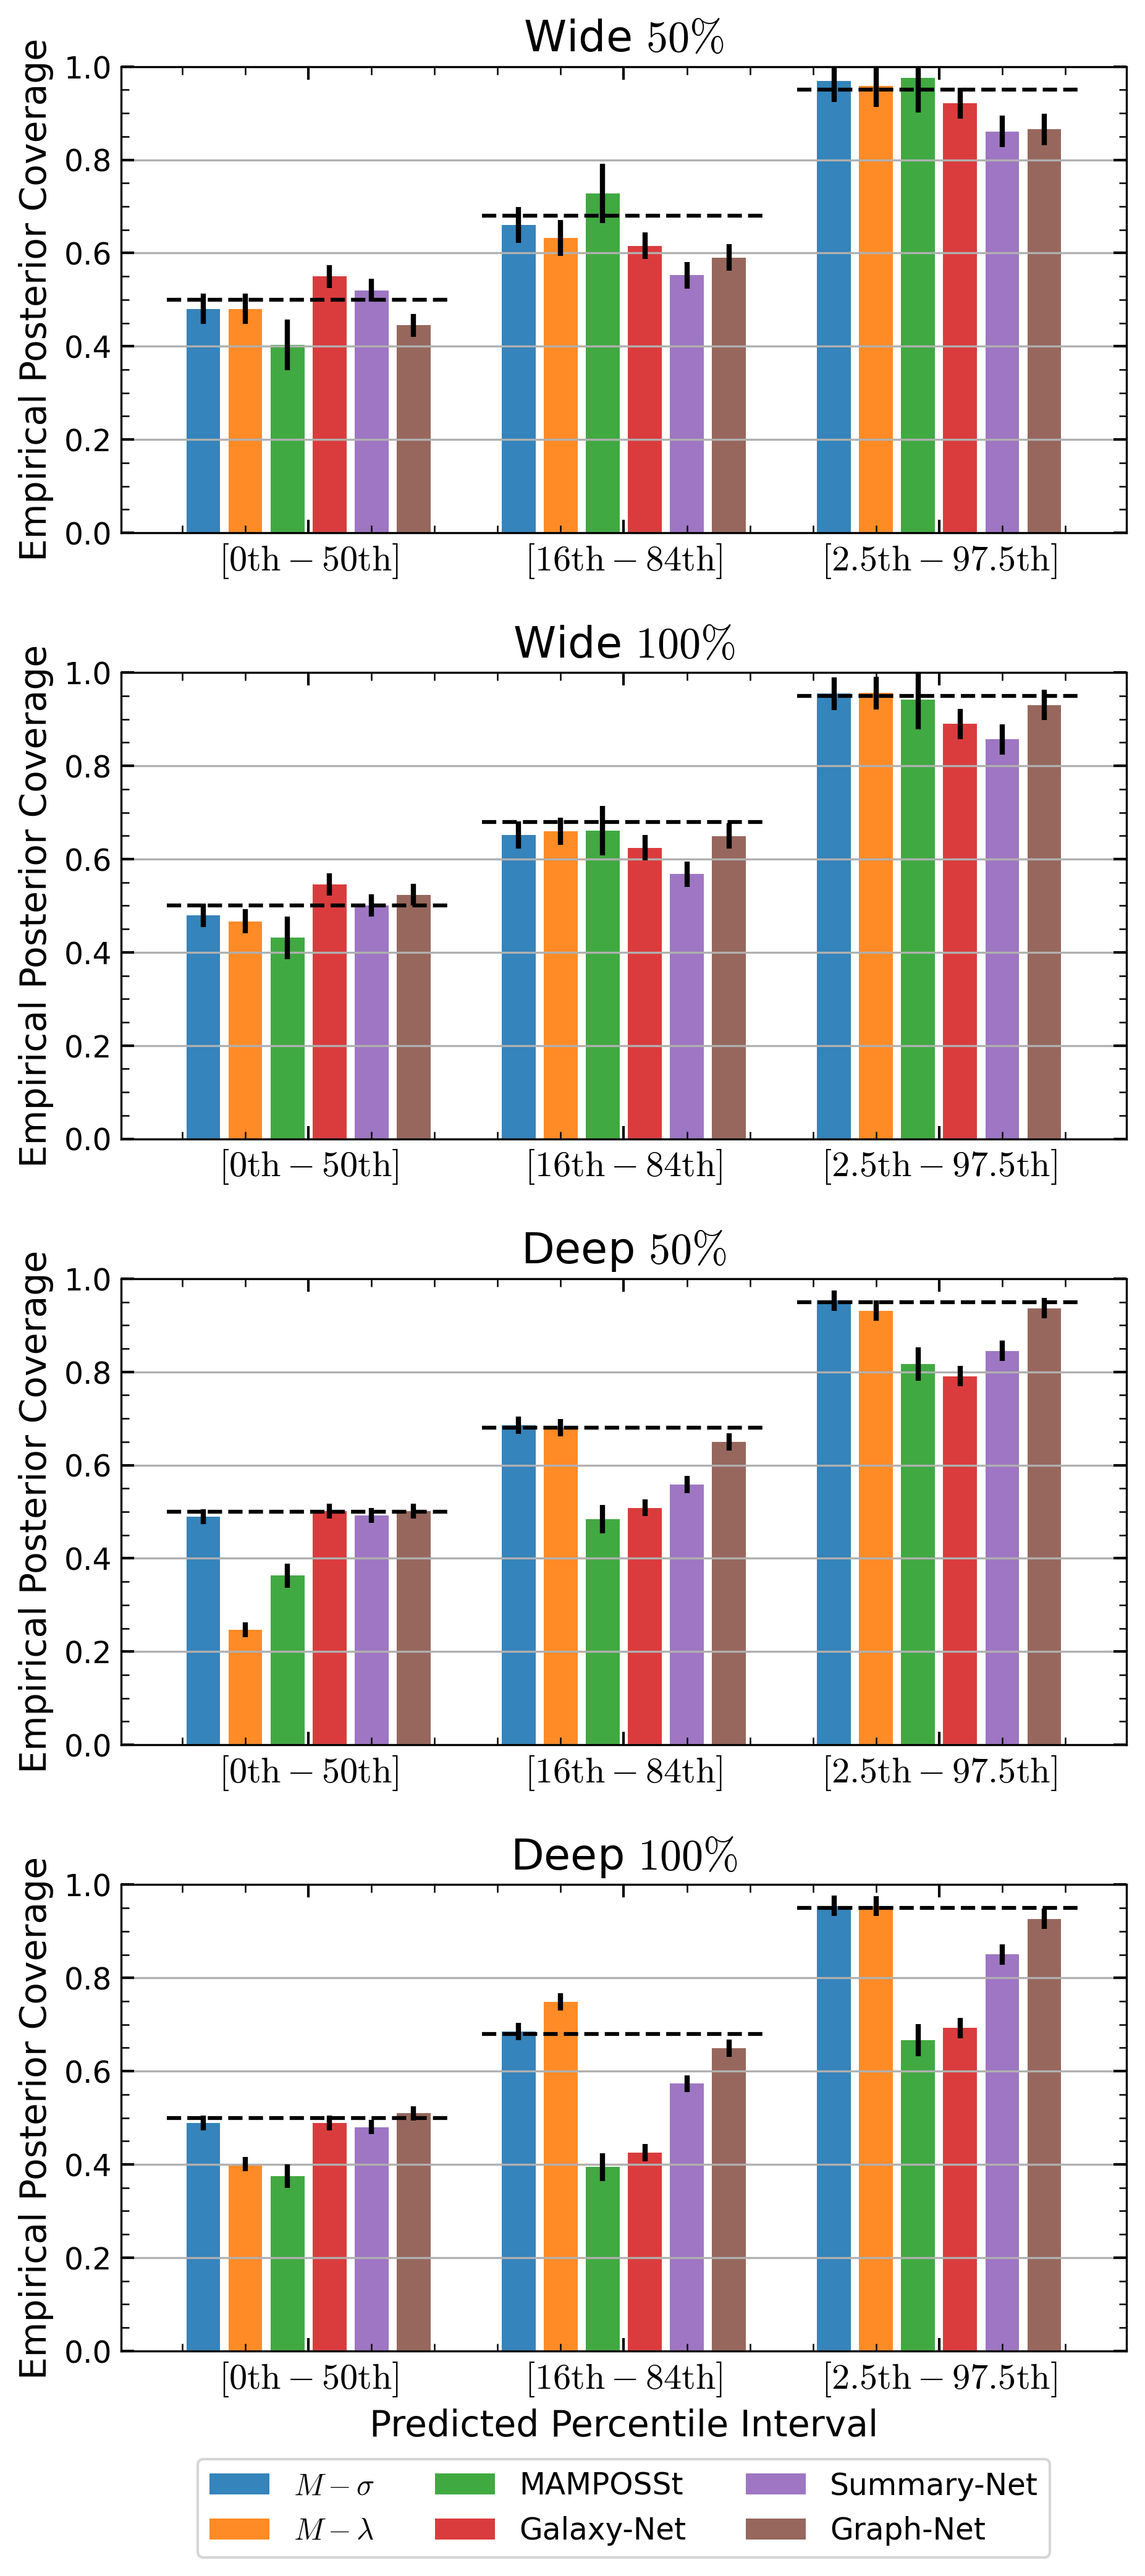

In [173]:
H, W = len(datanames), 1

f, axs = plt.subplots(
    H, W, figsize=(W*7, H*4), sharey=True,
    gridspec_kw={'hspace':0.3, 'wspace':0.1})
axs = axs.flatten()

for j, d in enumerate(datanames):
    ax = axs[j]

    cols = ['Model', 'Predicted Percentile Interval', 'Empirical Posterior Coverage', 'Error', 'Color']
    true_coverage = [0.5, 0.68, 0.95]
    df = pd.DataFrame(columns=cols)
    colors = sns.color_palette(n_colors=len(modelnames))
    for i, m in enumerate(modelnames):
        # calculate percentile difference
        _p = percs[d][m] - theta[d].T
        _p = _p[:,np.isnan(_p).sum(axis=0)==0]

        # calculate coverage
        fmedian = np.sum((_p[2]>0))/_p.shape[1]
        f1sig = np.sum((_p[0]<0) & (_p[1]>0))/_p.shape[1]
        f2sig = np.sum((_p[3]<0) & (_p[4]>0))/_p.shape[1]

        # calculate error
        emedian = np.sqrt(true_coverage[0]*_p.shape[1])/_p.shape[1]
        e1sig = np.sqrt(true_coverage[1]*_p.shape[1])/_p.shape[1]
        e2sig = np.sqrt(true_coverage[2]*_p.shape[1])/_p.shape[1]

        # append to dataframe
        dfi = pd.DataFrame(
            [[modeltitles[m], r'$[0{\rm th}-50{\rm th}]$', fmedian, emedian, colors[i]],
                [modeltitles[m], r'$[16{\rm th}-84{\rm th}]$', f1sig, e1sig, colors[i]],
                [modeltitles[m], r'$[2.5{\rm th}-97.5{\rm th}]$', f2sig, e2sig, colors[i]]],
            columns=cols
        )
        df = pd.concat([df, dfi])
    # df.sort_values(['Model', 'Percentile Interval'], inplace=True)

    sns.barplot(
        data=df, hue=cols[0], x=cols[1], y=cols[2],
        gap=0.2, alpha=0.9, saturation=1, ax=ax)

    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches][:len(df)]
    y_coords = [p.get_height() for p in ax.patches][:len(df)]
    for i in range(len(df)):
        ax.errorbar(
            x_coords[i], y_coords[i], yerr=df['Error'].iloc[i], 
            fmt='none', color='k', alpha=1)

    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), size = 14)
    for i, p in enumerate(true_coverage):
        x_ = np.array([i-0.45, i+0.45])
        ax.plot(x_, [p]*2, color='k', ls='--', lw=1.5)
    ax.set_title(datatitles[d])
    ax.legend().remove()
    if j != H-1:
        ax.set_xlabel(None)

axs[-1].legend(ncols=3, loc='upper center', bbox_to_anchor=(0.5, -0.2))
f.savefig('figures/coverage.pdf', bbox_inches='tight');

# Scratch

### Load mamposst

In [93]:
df = pd.read_csv('./saved_models/mamposst/result_MockFS_NewAMICO_deep50CUT.dat', 
                 delimiter=' ', skipinitialspace=True)
df['#ClusterID'] = df['#ClusterID'].astype(int)
df

#ClusterID  r200MAM  r200low(68)  r200up(68)  r200low(95)  r200up(95)  \
0             1   1.2430       1.1440      1.3500       1.0570      1.4830   
1             2   0.9453       0.8402      1.0670       0.7416      1.2050   
2             3   1.0460       0.9357      1.1730       0.8341      1.3300   
3             4   1.2280       1.1310      1.3420       1.0380      1.4730   
4             5   1.3100       1.1690      1.4810       1.0460      1.6930   
..          ...      ...          ...         ...          ...         ...   
742        3786   0.5868       0.4071      0.7692       0.0401      0.9832   
743        3795   0.7882       0.5881      1.0480       0.4014      1.4410   
744        3817   0.6160       0.4742      0.7884       0.3416      1.0120   
745        3818   0.5027       0.0401      0.7818       0.0401      1.2030   
746        3818   0.5027       0.0401      0.7818       0.0401      1.2030   

     r200True       z  Good   68  Good.1      95    NGal  -log(P)min  richness  
0        1.71  0.7914   0.0  0.0   119.0  988.60  119.80         NaN       NaN  
1        1.42  0.4129   0.0  0.0    88.0  691.10   55.97         NaN       NaN  
2        1.45  0.4101   0.0  0.0    78.0  619.90   53.59         NaN       NaN  
3        1.66  0.4421   0.0  0.0   122.0  977.60   65.86         NaN       NaN  
4        1.27  0.5452   1.0  1.0    60.0  492.50   49.03         NaN       NaN  
..        ...     ...   ...  ...     ...     ...     ...         ...       ...  
742      0.49  0.6129   1.0  1.0    31.0  235.10    7.72         NaN       NaN  
743      0.47  0.9146   0.0  1.0    13.0  101.20   20.88         NaN       NaN  
744      0.81  0.7286   0.0  1.0    27.0  207.40    9.92         NaN       NaN  
745      0.44  1.1300   1.0  1.0    11.0   84.67   15.33         NaN       NaN  
746      0.44  1.1300   1.0  1.0    11.0   84.67   15.33         NaN       NaN  

[747 rows x 15 columns]

In [104]:
# load mamposst
modeldir = './saved_models/mamposst/'

isamp = pd.read_csv(join(modeldir, 'result_MockFS_NewAMICO_deep100CUT.dat'), 
                    delimiter=' ', skipinitialspace=True)
isamp['id'] = isamp['#ClusterID'].astype(int)
isamp
# convert r200 to logm
for c in isamp.columns:
    if 'r200' not in c:
        continue
    isamp['logm'+c[4:]] = r2logm(isamp[c])

# put in preds
preds['dC100']['mamp'] = np.ones((Ndata['dC100'], 5))*np.nan
place_ids = np.searchsorted(ids['dC100'], isamp['id'].values)
_s = isamp[['logmlow(68)', 'logmup(68)', 'logmlow(95)', 'logmup(95)', 'logmMAM']].values
preds['dC100']['mamp'][place_ids] = _s

In [105]:
preds['dC100']['mamp']

array([[14.61480251, 14.75296722, 14.54887446, 14.82838248, 14.68206324],
       [14.32967582, 14.52385847, 14.23264769, 14.62493713, 14.42676024],
       [14.39801078, 14.60560644, 14.29189539, 14.72084164, 14.49942417],
       ...,
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [13.20858918, 13.70565287, 12.93836069, 13.96832825, 13.45719109]])

### M-\lambda

In [88]:
filename = 'data/processed/APR24dC100/x_sum.npy'
x = np.load(filename, allow_pickle=True)
filename = 'data/processed/APR24dC100/theta_batch.npy'
theta = np.load(filename, allow_pickle=True)

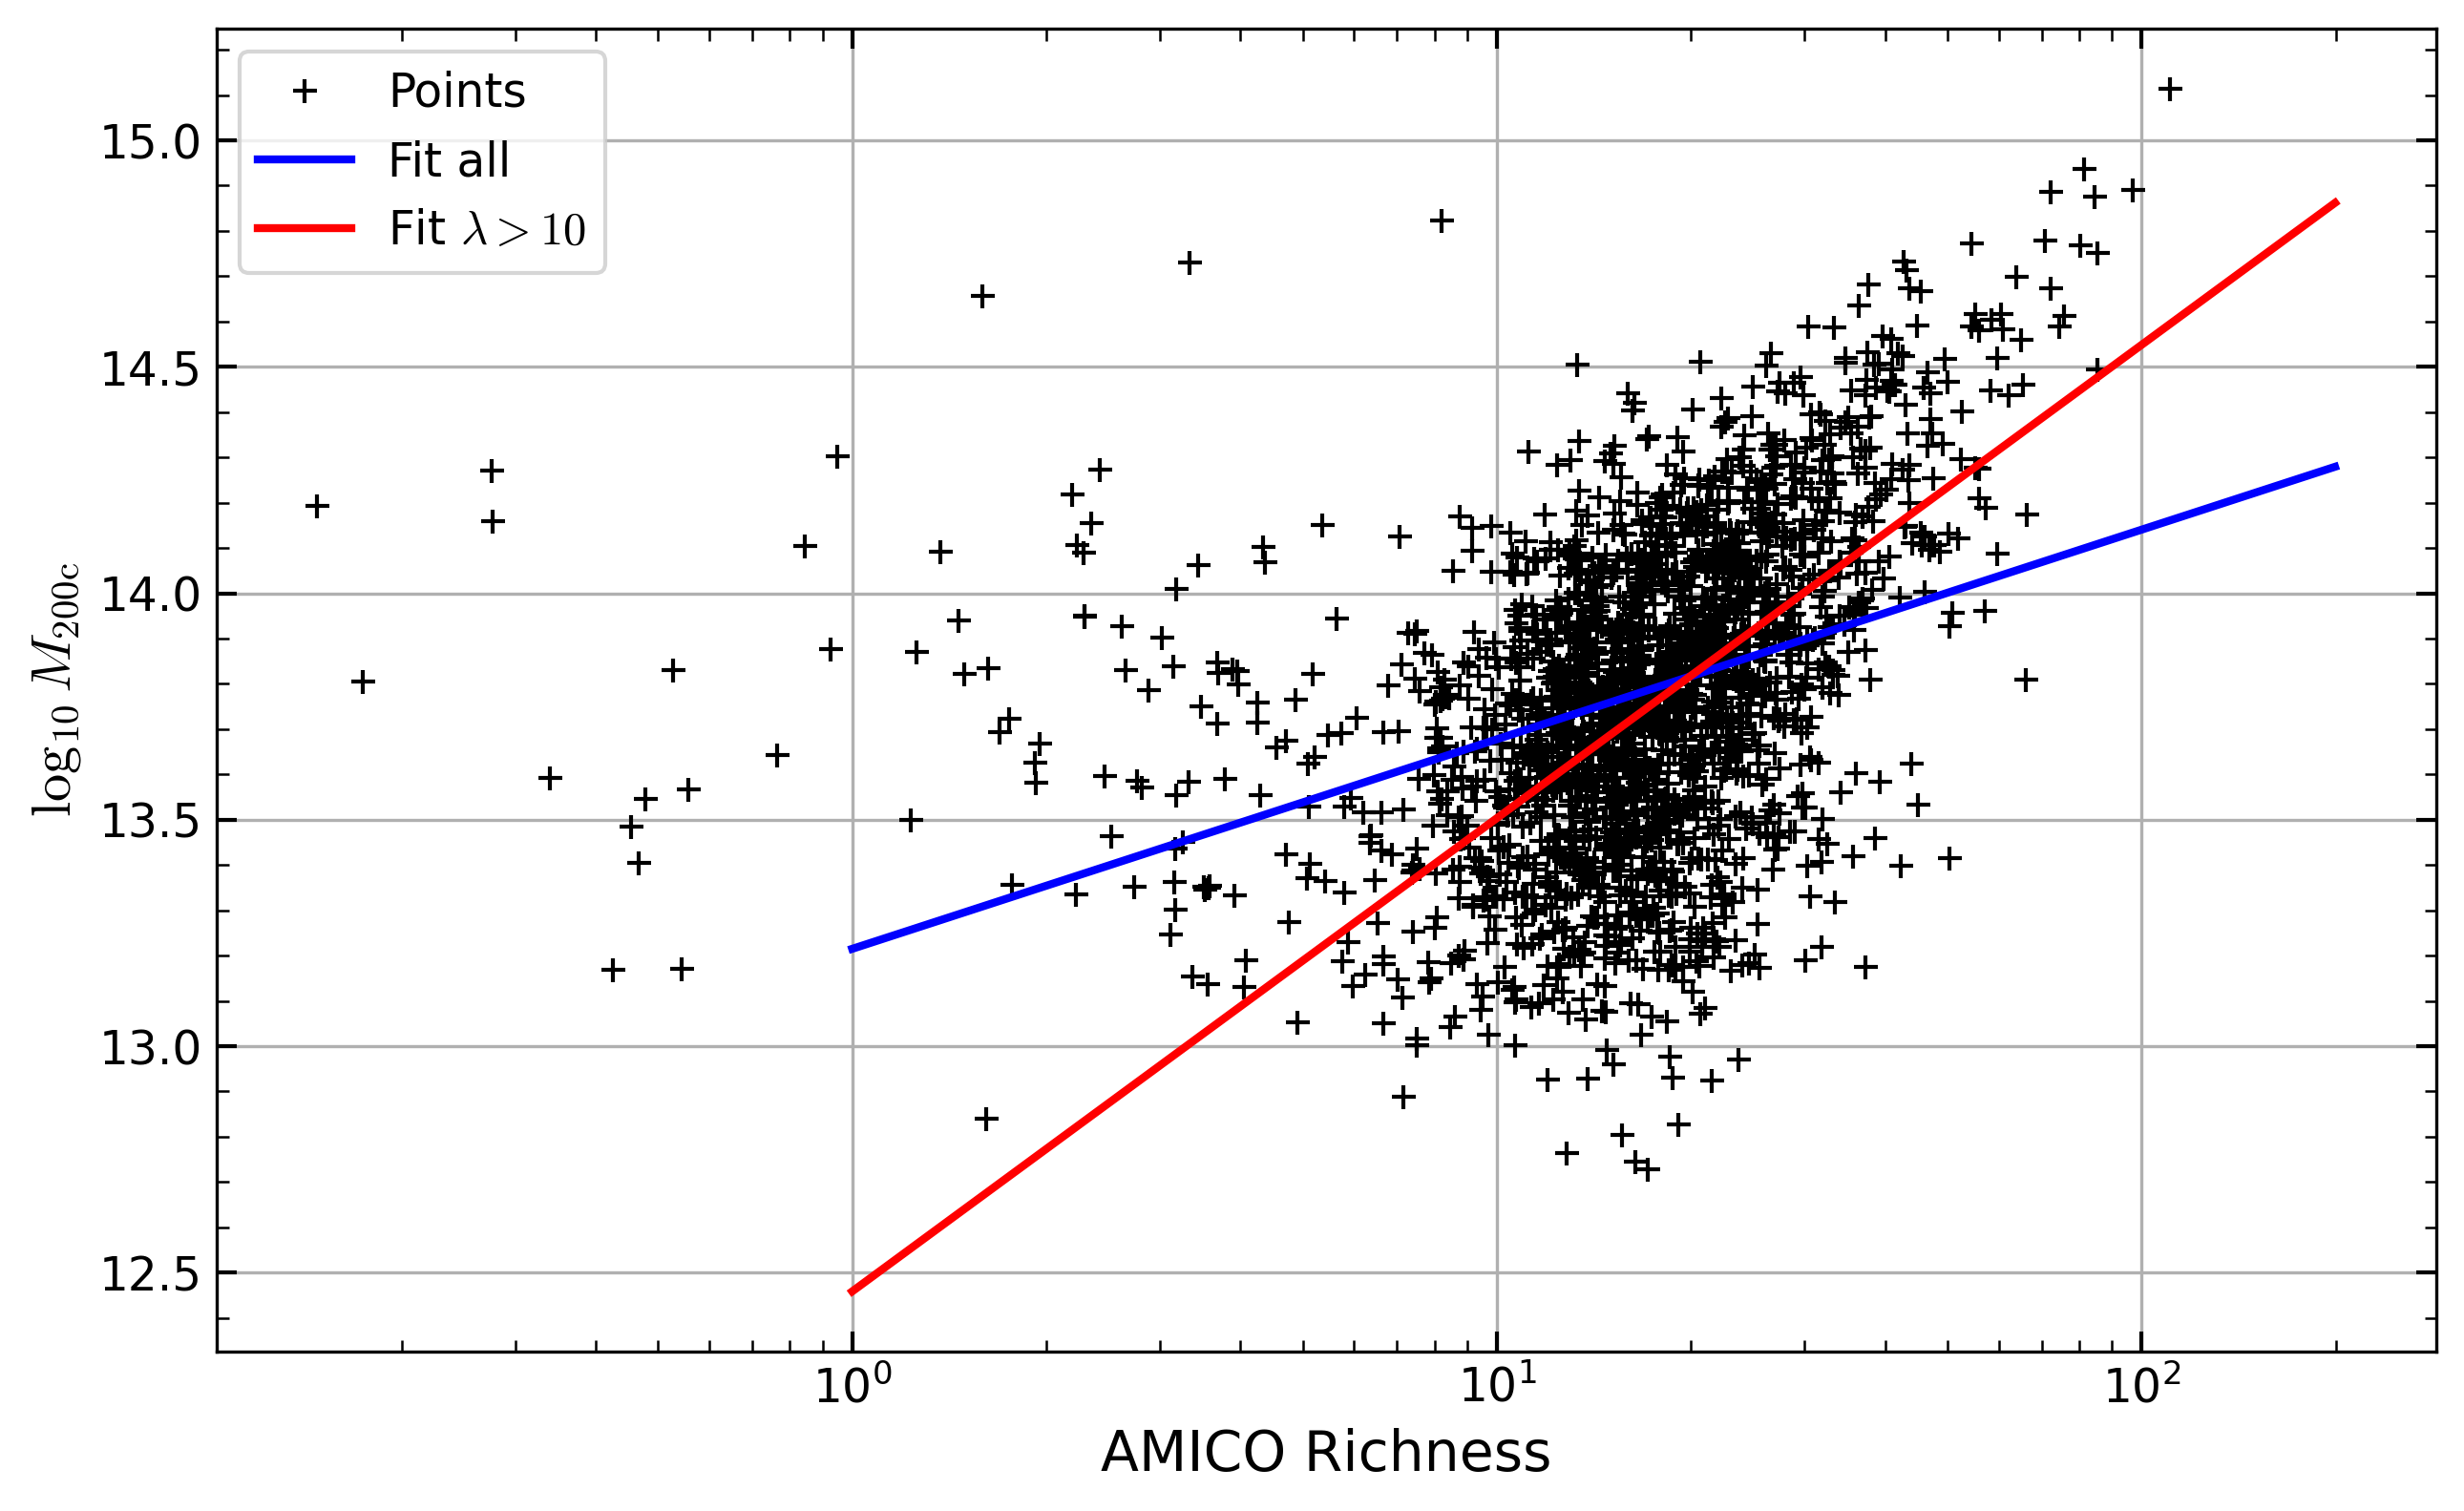

In [89]:
from sklearn.linear_model import LinearRegression


f, ax = plt.subplots()
ax.semilogx()
x_, y_ = x[:,3], theta
ax.plot(x_, y_, 'k+', label='Points')



x_, y_ = x[:,3], theta
mask = x_>0
reg = LinearRegression().fit(np.log10(x_[mask,None]), y_[mask])
x_ = np.linspace(0, 2.3, 100)[:,None]
y_ = reg.predict(x_)
ax.plot(10**x_, y_, 'b', label=r'Fit all')


x_, y_ = x[:,3], theta
mask = x_>10
reg = LinearRegression().fit(np.log10(x_[mask,None]), y_[mask])
x_ = np.linspace(0, 2.3, 100)[:,None]
y_ = reg.predict(x_)
ax.plot(10**x_, y_, 'r', label=r'Fit $\lambda>10$')

# ax.set_xlim(1)
ax.set_xlabel('AMICO Richness')
ax.set_ylabel(r'$\log_{10}M_{\rm 200c}$')
ax.legend()